In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 16.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=cf352f9e37cafe447b7f057968cbb702c70c62946e56d137430652a11abd3d66
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import sql
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Create spark session
spark = SparkSession.builder.appName('EDA').getOrCreate()

In [ ]:
# Read data
df = spark.read.option('header', 'true').csv('/content/drive/MyDrive/BI/KAG_conversion_data.csv', inferSchema=True)

In [ ]:
# Get the schema info
df.printSchema()

root
 |-- ad_id: integer (nullable = true)
 |-- xyz_campaign_id: integer (nullable = true)
 |-- fb_campaign_id: integer (nullable = true)
 |-- age: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- interest: integer (nullable = true)
 |-- Impressions: integer (nullable = true)
 |-- Clicks: integer (nullable = true)
 |-- Spent: double (nullable = true)
 |-- Total_Conversion: integer (nullable = true)
 |-- Approved_Conversion: integer (nullable = true)



In [ ]:
df.show()

+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+
| ad_id|xyz_campaign_id|fb_campaign_id|  age|gender|interest|Impressions|Clicks|      Spent|Total_Conversion|Approved_Conversion|
+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+
|708746|            916|        103916|30-34|     M|      15|       7350|     1|1.429999948|               2|                  1|
|708749|            916|        103917|30-34|     M|      16|      17861|     2|1.820000023|               2|                  0|
|708771|            916|        103920|30-34|     M|      20|        693|     0|        0.0|               1|                  0|
|708815|            916|        103928|30-34|     M|      28|       4259|     1|       1.25|               1|                  0|
|708818|            916|        103928|30-34|     M|      28|       4133|     1|1.28999996

In [ ]:
df.count()

1143

In [ ]:
# Create a temp view for this session
df.select('ad_id',
 'xyz_campaign_id',
 'fb_campaign_id',
 'age',
 'gender',
 'interest',
 'Impressions',
 'Clicks',
 'Spent',
 'Total_Conversion',
 'Approved_Conversion').createOrReplaceTempView("df")

# Sanity Check

## Check missing values

In [ ]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----+---------------+--------------+---+------+--------+-----------+------+-----+----------------+-------------------+
|ad_id|xyz_campaign_id|fb_campaign_id|age|gender|interest|Impressions|Clicks|Spent|Total_Conversion|Approved_Conversion|
+-----+---------------+--------------+---+------+--------+-----------+------+-----+----------------+-------------------+
|    0|              0|             0|  0|     0|       0|          0|     0|    0|               0|                  0|
+-----+---------------+--------------+---+------+--------+-----------+------+-----+----------------+-------------------+



From the query, we find that the data frame contains no null/nan values

## Check duplicate values

In [ ]:
df.distinct().count()

1143

We can see that there are no duplicate values, the number of unique record is equal to the number of rows

## Figure out the features

All the columns seems to be easy to understand from its definition, except for the column 'fb_campaign_id'. Let's figure out how they indexed this!

### fb_campaign_id

In [ ]:
spark.sql("SELECT COUNT(DISTINCT fb_campaign_id) FROM df").show(10)

+------------------------------+
|count(DISTINCT fb_campaign_id)|
+------------------------------+
|                           691|
+------------------------------+



In [ ]:
spark.sql("SELECT xyz_campaign_id, fb_campaign_id, gender, age, interest, Spent FROM df WHERE fb_campaign_id IN \
            (SELECT fb_campaign_id FROM df GROUP BY fb_campaign_id HAVING COUNT(fb_campaign_id) > 1)").show()

+---------------+--------------+------+-----+--------+-----------+
|xyz_campaign_id|fb_campaign_id|gender|  age|interest|      Spent|
+---------------+--------------+------+-----+--------+-----------+
|            916|        103928|     M|30-34|      28|       1.25|
|            916|        103928|     M|30-34|      28|1.289999962|
|            916|        103965|     M|30-34|      16|        0.0|
|            916|        103965|     M|30-34|      16|        0.0|
|            916|        104012|     M|35-39|      15|        0.0|
|            916|        104012|     M|35-39|      15|2.609999895|
|            916|        104013|     M|35-39|      16|3.049999952|
|            916|        104013|     M|35-39|      16|3.059999943|
|            916|        104013|     M|35-39|      16|        0.0|
|            916|        104085|     M|40-44|      16|1.690000057|
|            916|        104085|     M|40-44|      16|        0.0|
|            916|        104205|     F|30-34|      16|        

We can see that, with similar fb_campaign_id, the xyz_id, gender, age, interest are the same, only the Spent is different. Hence, fb_cp_id might be the same campaign ad with the same group of customers but with different budget.

## Check outliers

### Spent

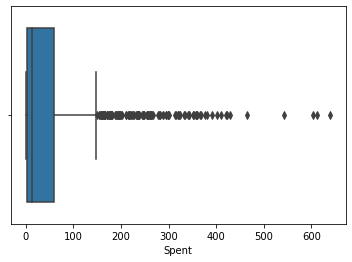

In [ ]:
sns.boxplot(x=df.toPandas()["Spent"])

In [ ]:
from pyspark.sql.functions import col
df.sort(col("Spent").desc()).show()

+-------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+
|  ad_id|xyz_campaign_id|fb_campaign_id|  age|gender|interest|Impressions|Clicks|      Spent|Total_Conversion|Approved_Conversion|
+-------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+
|1121100|           1178|        144532|30-34|     M|      15|    3052003|   340|639.9499981|              60|                 17|
|1121814|           1178|        144659|30-34|     F|      27|    2223278|   421|612.3000032|              38|                 13|
|1121601|           1178|        144624|45-49|     M|      16|    2286228|   353| 603.380002|              16|                  7|
|1122265|           1178|        144734|45-49|     F|      27|    1428421|   367|541.7000023|              10|                  0|
|1122193|           1178|        144722|45-49|     F|      10|    1358324|   346|46

### Impressions

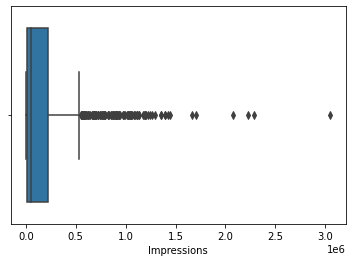

In [ ]:
sns.boxplot(x=df.toPandas()["Impressions"])

In [ ]:
from pyspark.sql.functions import col
df.sort(col("Impressions").desc()).show()

+-------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+
|  ad_id|xyz_campaign_id|fb_campaign_id|  age|gender|interest|Impressions|Clicks|      Spent|Total_Conversion|Approved_Conversion|
+-------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+
|1121100|           1178|        144532|30-34|     M|      15|    3052003|   340|639.9499981|              60|                 17|
|1121601|           1178|        144624|45-49|     M|      16|    2286228|   353| 603.380002|              16|                  7|
|1121814|           1178|        144659|30-34|     F|      27|    2223278|   421|612.3000032|              38|                 13|
|1121104|           1178|        144533|30-34|     M|      16|    2080666|   202|360.1500015|              40|                 21|
|1121824|           1178|        144661|30-34|     F|      29|    1705246|   295|42

### Clicks

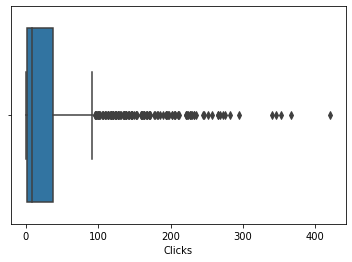

In [ ]:
sns.boxplot(x=df.toPandas()["Clicks"])

In [ ]:
from pyspark.sql.functions import col
df.sort(col("Clicks").desc()).show()

+-------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+
|  ad_id|xyz_campaign_id|fb_campaign_id|  age|gender|interest|Impressions|Clicks|      Spent|Total_Conversion|Approved_Conversion|
+-------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+
|1121814|           1178|        144659|30-34|     F|      27|    2223278|   421|612.3000032|              38|                 13|
|1122265|           1178|        144734|45-49|     F|      27|    1428421|   367|541.7000023|              10|                  0|
|1121601|           1178|        144624|45-49|     M|      16|    2286228|   353| 603.380002|              16|                  7|
|1122193|           1178|        144722|45-49|     F|      10|    1358324|   346|465.0799981|               8|                  2|
|1121100|           1178|        144532|30-34|     M|      15|    3052003|   340|63

### Total_Conversion

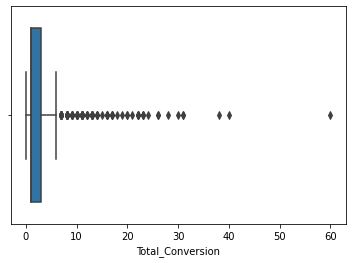

In [ ]:
sns.boxplot(x=df.toPandas()["Total_Conversion"])

In [ ]:
from pyspark.sql.functions import col
df.sort(col("Total_Conversion").desc()).show()

+-------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+
|  ad_id|xyz_campaign_id|fb_campaign_id|  age|gender|interest|Impressions|Clicks|      Spent|Total_Conversion|Approved_Conversion|
+-------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+
|1121100|           1178|        144532|30-34|     M|      15|    3052003|   340|639.9499981|              60|                 17|
|1121104|           1178|        144533|30-34|     M|      16|    2080666|   202|360.1500015|              40|                 21|
|1121814|           1178|        144659|30-34|     F|      27|    2223278|   421|612.3000032|              38|                 13|
|1121196|           1178|        144552|30-34|     M|      28|    1392288|   206|358.5500029|              31|                  7|
|1314387|           1178|        179954|40-44|     F|     101|     696612|   152|22

### Approved_Conversion

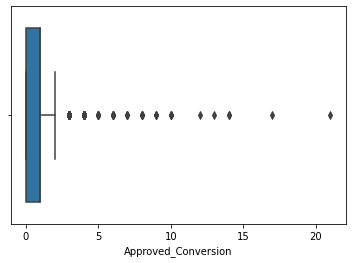

In [ ]:
sns.boxplot(x=df.toPandas()["Approved_Conversion"])

## Check for constraints violation


We test some constraints that can be inferred from the definition of columns:

*   If Spent = 0 then Impressions, Clicks, Total_Conversion, Approved_Conversion = 0
*   Approved_Conversion < Total Conversions < Clicks < Impressions

In [ ]:
spark.sql("SELECT count(*) \
            FROM df \
            WHERE Spent = 0 AND (Impressions > 0 OR Clicks > 0 OR Total_Conversion > 0 OR Approved_Conversion > 0)").show()

+--------+
|count(1)|
+--------+
|     207|
+--------+



There are 207 records does not satisfy the first constraints, let's see where it comes from

In [ ]:
spark.sql("SELECT count(*) \
            FROM df \
            WHERE Spent = 0 AND (Impressions > 0)").show()

+--------+
|count(1)|
+--------+
|     207|
+--------+



In [ ]:
spark.sql("SELECT count(*) \
            FROM df \
            WHERE Spent = 0 AND (Clicks > 0)").show()

+--------+
|count(1)|
+--------+
|       0|
+--------+



In [ ]:
spark.sql("SELECT count(*) \
            FROM df \
            WHERE Spent = 0 AND (Total_Conversion > 0)").show()

+--------+
|count(1)|
+--------+
|     204|
+--------+



In [ ]:
spark.sql("SELECT count(*) \
            FROM df \
            WHERE Spent = 0 AND (Approved_Conversion > 0)").show()

+--------+
|count(1)|
+--------+
|      71|
+--------+



The contraints violation mostly comes from the Impression. In practice, we thought of this as the cases that the auto-recommender system of facebook recommend the ads for users that have the same taste with the targeted users, or the friend lists of the targeted users. 

In [ ]:
spark.sql("SELECT * \
            FROM df \
            WHERE Clicks > Impressions").show()

+-----+---------------+--------------+---+------+--------+-----------+------+-----+----------------+-------------------+
|ad_id|xyz_campaign_id|fb_campaign_id|age|gender|interest|Impressions|Clicks|Spent|Total_Conversion|Approved_Conversion|
+-----+---------------+--------------+---+------+--------+-----------+------+-----+----------------+-------------------+
+-----+---------------+--------------+---+------+--------+-----------+------+-----+----------------+-------------------+



In [ ]:
spark.sql("SELECT COUNT(*) \
            FROM df \
            WHERE Total_Conversion > Clicks").show()

+--------+
|count(1)|
+--------+
|     218|
+--------+



In [ ]:
spark.sql("SELECT COUNT(*) \
            FROM df \
            WHERE Approved_Conversion > Clicks").show()

+--------+
|count(1)|
+--------+
|      72|
+--------+



In [ ]:
spark.sql("SELECT COUNT(*) \
            FROM df \
            WHERE Total_Conversion > Impressions").show()
spark.sql("SELECT COUNT(*) \
            FROM df \
            WHERE Approved_Conversion > Impressions").show()

+--------+
|count(1)|
+--------+
|       0|
+--------+

+--------+
|count(1)|
+--------+
|       0|
+--------+



In [ ]:
spark.sql("SELECT * \
            FROM df \
            WHERE Approved_Conversion > Total_Conversion").show()

+-----+---------------+--------------+---+------+--------+-----------+------+-----+----------------+-------------------+
|ad_id|xyz_campaign_id|fb_campaign_id|age|gender|interest|Impressions|Clicks|Spent|Total_Conversion|Approved_Conversion|
+-----+---------------+--------------+---+------+--------+-----------+------+-----+----------------+-------------------+
+-----+---------------+--------------+---+------+--------+-----------+------+-----+----------------+-------------------+



Also, there are some none-clicked ads but still have conversions. We can see that not all enquiries/sales comes from the ads.

# EDA: Visualization

Only for this section, we query and transform pyspark Data Frame into Pandas Data Frame for a better visualization.

## Overview

In [ ]:
df.summary().show()

+-------+------------------+------------------+------------------+-----+------+------------------+------------------+-----------------+-----------------+------------------+-------------------+
|summary|             ad_id|   xyz_campaign_id|    fb_campaign_id|  age|gender|          interest|       Impressions|           Clicks|            Spent|  Total_Conversion|Approved_Conversion|
+-------+------------------+------------------+------------------+-----+------+------------------+------------------+-----------------+-----------------+------------------+-------------------+
|  count|              1143|              1143|              1143| 1143|  1143|              1143|              1143|             1143|             1143|              1143|               1143|
|   mean| 987261.1303587052|1067.3823272090988|133783.98950131235| null|  null| 32.76640419947507| 186732.1329833771|33.39020122484689|51.36065613141293|2.8556430446194225| 0.9440069991251093|
| stddev|193992.81473824303|121.629

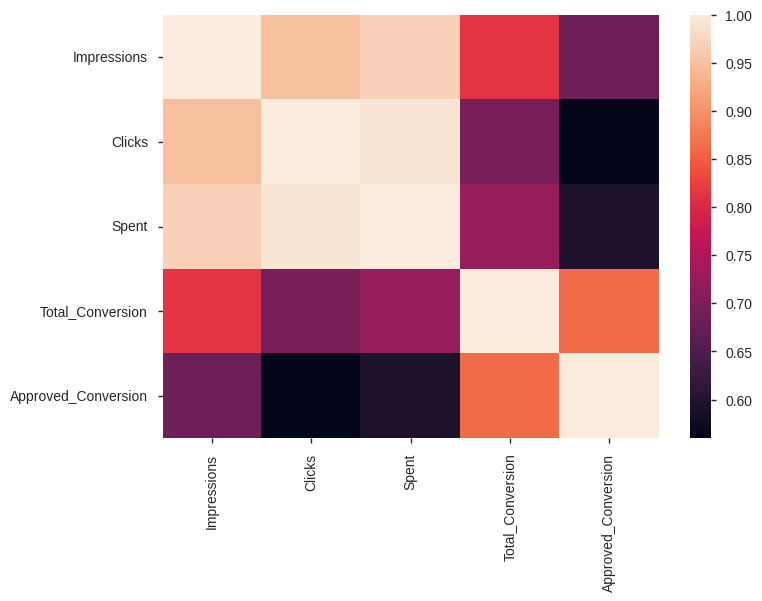

In [ ]:
sns.heatmap(df.select(
            'Impressions',
            'Clicks',
            'Spent',
            'Total_Conversion',
            'Approved_Conversion').toPandas().corr())

It is clearly see that Spent, Clicks, Impressions are highly correlated with each other, the same goes for Total_Conversion and Approved Conversion

## Functions

In [ ]:
def uni_eda(feat, ftype, scale=None, prob=False, agg='count', palette=None, font_scale=1):
  spark.sql("SELECT COUNT(DISTINCT {}) FROM df".format(feat)).show()
  spark.sql("SELECT DISTINCT {} FROM df".format(feat)).show()

  spark.sql("SELECT {0},count(*) \
            FROM df \
            GROUP BY {0}".format(feat)).show()

  spark.sql("SELECT {0}, {1}(Impressions) Impressions, \
            {1}(Clicks) Clicks, \
            {1}(Spent) Spent, \
            {1}(Total_conversion) Total_conversion, \
            {1}(Approved_conversion) Approved_conversion \
            FROM df \
            GROUP BY {0}".format(feat, agg)).show()
  sns.set(font_scale = font_scale)
  sns.set_style('whitegrid')
  sns.barplot(
        x=feat, 
        y='count', 
        data=spark.sql("SELECT {0},count(*) count \
            FROM df \
            GROUP BY {0}".format(feat)).toPandas(),
        palette=palette
    )
  plt.savefig("{}_uni.png".format(feat))
  
  # sns.set(font_scale = 2)
  fig, axes=plt.subplots(nrows=1, ncols=5, figsize=(50,10))
  i=0
  for col in ['Impressions',
              'Clicks',
              'Spent',
              'Total_Conversion',
              'Approved_Conversion']:
    sns.set_style('whitegrid')
    sns.barplot(
        x=feat, 
        y=col, 
        data=spark.sql("SELECT {0}, {1}(Impressions) Impressions, \
                {1}(Clicks) Clicks, \
                {1}(Spent) Spent, \
                {1}(Total_Conversion) Total_Conversion, \
                {1}(Approved_Conversion) Approved_Conversion \
                FROM df \
                GROUP BY {0}".format(feat, agg)).toPandas(),
        ax=axes[i]
    )    
    if scale:
      axes[i].set_yscale(scale)
    # axes[i].set_ylabel(col, fontsize=40)
    # axes[i].set_xlabel(feat, fontsize=40)
    # axes[i].set_yticklabels(fontsize=40)
    # axes[i].set_xticklabels(fontsize=40)
    i += 1    
  sns.despine()


In [ ]:
def var2(feat1, feat2, scale=None, agg='avg'):
    spark.sql("SELECT {0}, {1}, \
                    {3}(Impressions) Impressions, \
                    {3}(Clicks) Clicks, \
                    {3}(Spent) Spent, \
                    {3}(Total_Conversion) Total_Conversion, \
                    {3}(Approved_Conversion) Approved_Conversion \
                    FROM df \
                    GROUP BY {0}, {1}, {3}".format(feat1, feat2, agg)).show()
    fig, axes=plt.subplots(nrows=1, ncols=5, figsize=(100,20))
    i=0
    for col in ['Impressions',
                'Clicks',
                'Spent',
                'Total_Conversion',
                'Approved_Conversion']:
        sns.barplot(
            x=feat1, y=col, hue=feat2,
            data=spark.sql("SELECT {0}, {1}, \
                        {3}(Impressions) Impressions, \
                        {3}(Clicks) Clicks, \
                        {3}(Spent) Spent, \
                        {3}(Total_Conversion) Total_Conversion, \
                        {3}(Approved_Conversion) Approved_Conversion \
                        FROM df \
                        GROUP BY {0}, {1}, {3}".format(feat1, feat2, agg)).toPandas(), 
            ax=axes[i]
        )
        if scale:
            axes[i].set_yscale("log")
        axes[i].set_ylabel(col, fontsize=40)
        axes[i].set_xlabel(feat1, fontsize=40)
        axes[i].legend(fontsize=40)
            # axes[i].set_yticklabels(fontsize=40)
            # axes[i].set_xticklabels(fontsize=40)
        i += 1 

## Categorical Variables

### Campaign

In [ ]:
uni_eda("xyz_campaign_id", "cat", agg='count', palette=['#BB2649','#FFE4EA','#2B526B'])

In [ ]:
var2('xyz_campaign_id', 'age', scale='log')

In [ ]:
var2('xyz_campaign_id', 'gender', scale='log')

In [ ]:
var2('xyz_campaign_id', 'interest', scale='log')

###Age

In [ ]:
uni_eda("age", "cat", agg='count', palette=['#BB2649','#FFE4EA', '#91AEB9' ,'#2B526B'])

In [ ]:
uni_eda("age", "cat", agg='avg')

The age 45-49 is spent on a lot, got a lot of impressions and clicks but less enquirement and sales. 
In contrast, the group 30-34 have highest conversions though spent amount is less than 45-49

+-----+---------------+-----------+------+------------------+----------------+-------------------+
|  age|xyz_campaign_id|Impressions|Clicks|             Spent|Total_Conversion|Approved_Conversion|
+-----+---------------+-----------+------+------------------+----------------+-------------------+
|35-39|            936|    1111675|   275|383.43000145900004|              96|                 34|
|30-34|            916|     257672|    57|      75.330000188|              31|                 11|
|30-34|            936|    1655949|   286|     391.440000331|             227|                 88|
|40-44|           1178|   38338733|  7411|   11122.519980763|             433|                141|
|40-44|            916|      61977|    14|        16.8100003|               7|                  4|
|45-49|           1178|   59493692| 12715|19048.639999101004|             546|                169|
|35-39|            916|      81076|    17|23.639999985000003|              13|                  6|
|45-49|   

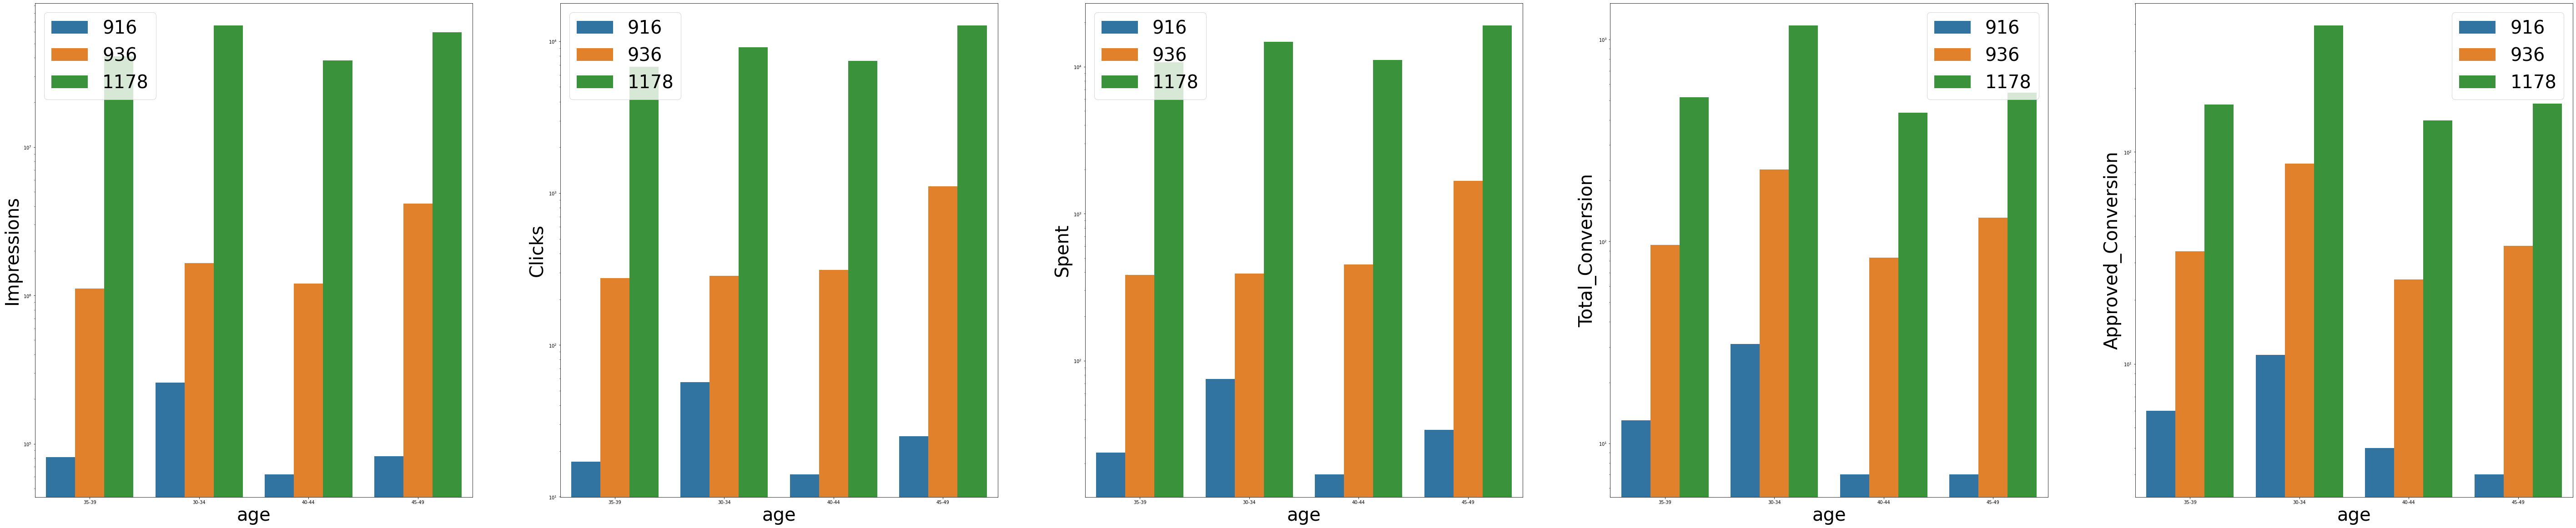

In [ ]:
var2('age', 'xyz_campaign_id', scale='log')

+-----+------+-----------+------+------------------+----------------+-------------------+
|  age|gender|Impressions|Clicks|             Spent|Total_Conversion|Approved_Conversion|
+-----+------+-----------+------+------------------+----------------+-------------------+
|35-39|     F|   21439505|  4161| 6061.349991827001|             304|                 95|
|45-49|     M|   25277267|  4411| 7317.460003877001|             285|                 96|
|35-39|     M|   20665139|  2933|    5051.080002508|             322|                112|
|45-49|     F|   38455591|  9441|13433.209992777003|             399|                112|
|40-44|     F|   23396175|  5177| 7396.579983637003|             322|                 93|
|40-44|     M|   16208132|  2559|    4193.149997201|             201|                 77|
|30-34|     M|   36421443|  4384| 7640.919991250997|             812|                299|
|30-34|     F|   31571576|  5099| 7611.479995126999|             619|                195|
+-----+---

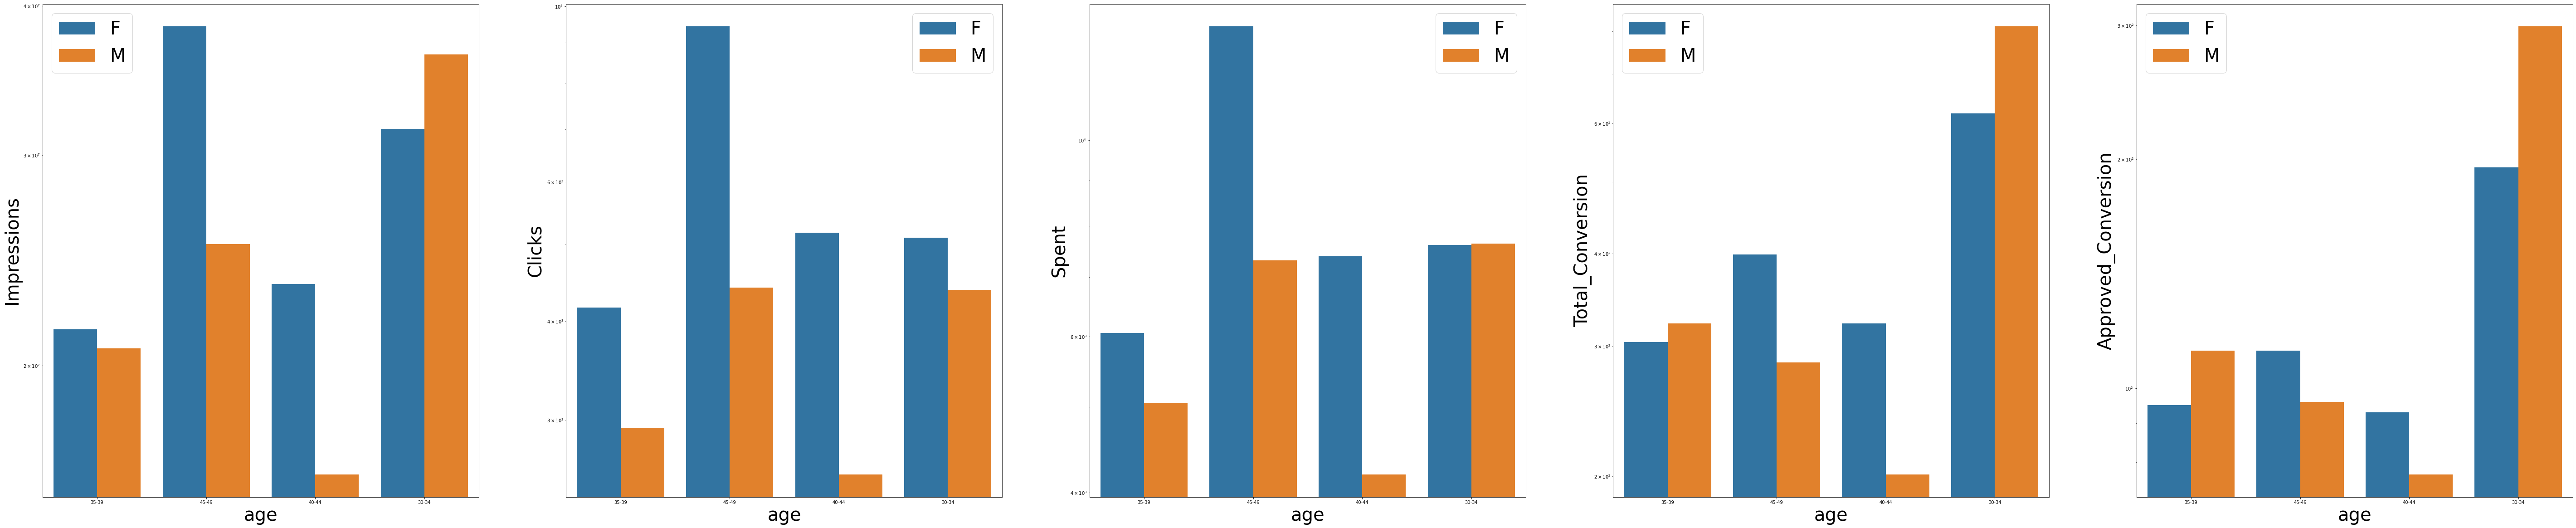

In [ ]:
var2('age', 'gender', scale='log')

###Gender

+------+
|gender|
+------+
|     F|
|     M|
+------+

+------+--------+
|gender|count(1)|
+------+--------+
|     F|     551|
|     M|     592|
+------+--------+

+------+-----------+------+-----+----------------+-------------------+
|gender|Impressions|Clicks|Spent|Total_conversion|Approved_conversion|
+------+-----------+------+-----+----------------+-------------------+
|     F|        551|   551|  551|             551|                551|
|     M|        592|   592|  592|             592|                592|
+------+-----------+------+-----+----------------+-------------------+



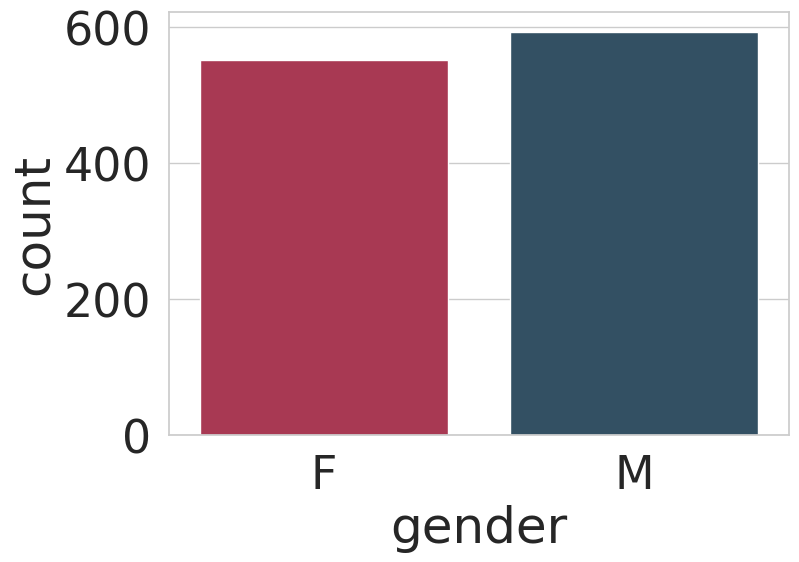

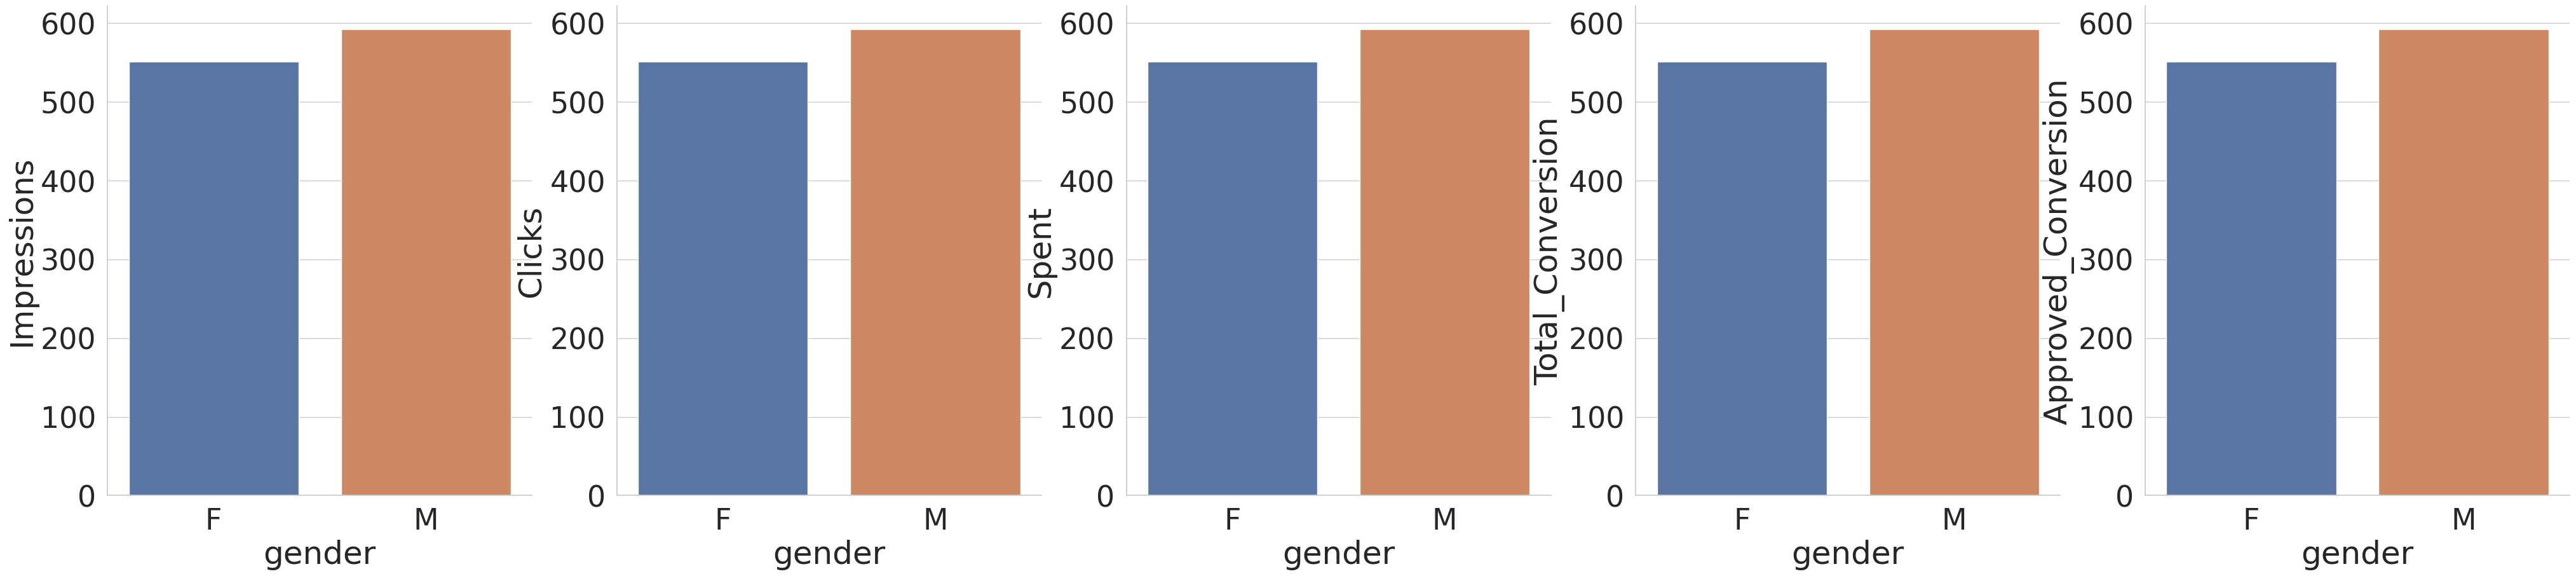

In [ ]:
uni_eda("gender", "cat", agg='count', palette=['#BB2649','#2B526B'])

Although Female is invested in more, and they have higher impressions/clicks but Male tends to buy the product after clicks more.

+------+
|gender|
+------+
|     F|
|     M|
+------+

+------+--------+
|gender|count(1)|
+------+--------+
|     F|     551|
|     M|     592|
+------+--------+

+------+------------------+------------------+-----------------+------------------+-------------------+
|gender|       Impressions|            Clicks|            Spent|  Total_conversion|Approved_conversion|
+------+------------------+------------------+-----------------+------------------+-------------------+
|     F| 208462.5172413793| 43.33575317604356| 62.6181850514846| 2.983666061705989| 0.8983666061705989|
|     M|166506.72466216216|24.133445945945947|40.88278715344088|2.7364864864864864| 0.9864864864864865|
+------+------------------+------------------+-----------------+------------------+-------------------+



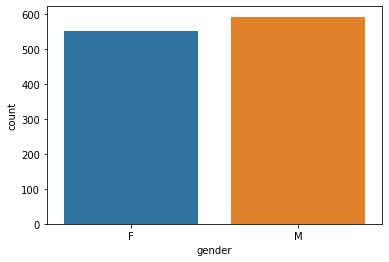

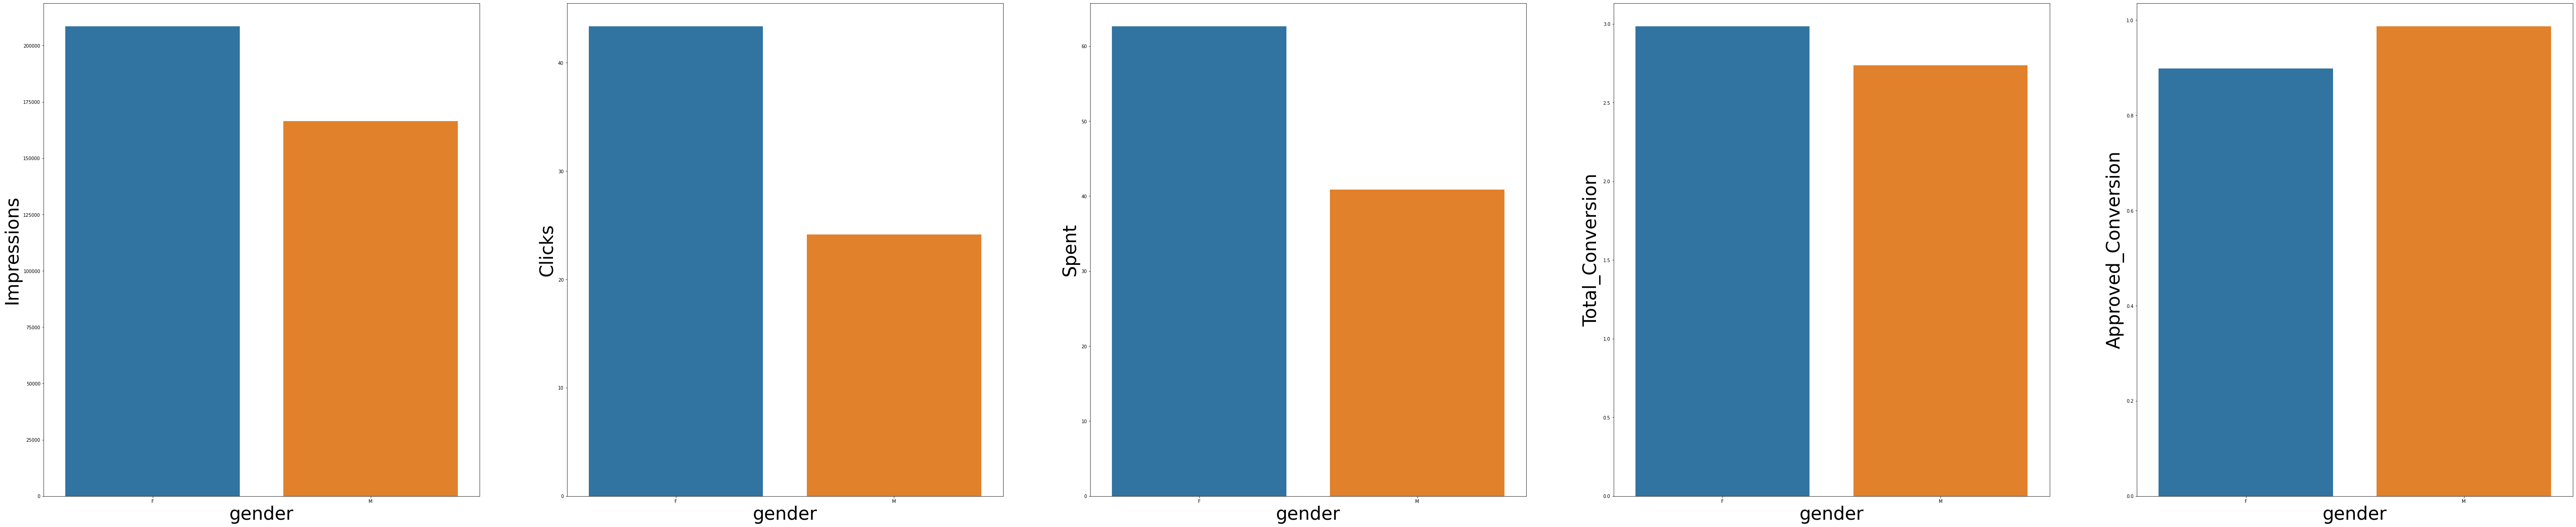

In [ ]:
uni_eda("gender", "cat", agg='avg')

###Interest

+------------------------+
|count(DISTINCT interest)|
+------------------------+
|                      40|
+------------------------+

+--------+
|interest|
+--------+
|      31|
|      65|
|     108|
|     101|
|      28|
|      27|
|      26|
|     103|
|      22|
|     111|
|      16|
|      20|
|      19|
|      64|
|      15|
|     112|
|     107|
|     114|
|     100|
|      23|
+--------+
only showing top 20 rows

+--------+--------+
|interest|count(1)|
+--------+--------+
|      31|      25|
|      65|      19|
|     108|       7|
|     101|       7|
|      28|      51|
|      27|      60|
|      26|      41|
|     103|       5|
|      22|      33|
|     111|       6|
|      16|     140|
|      20|      49|
|      19|      32|
|      64|      48|
|      15|      51|
|     112|       7|
|     107|       8|
|     114|       5|
|     100|       6|
|      23|      23|
+--------+--------+
only showing top 20 rows

+--------+-----------+------+-----+----------------+----------------

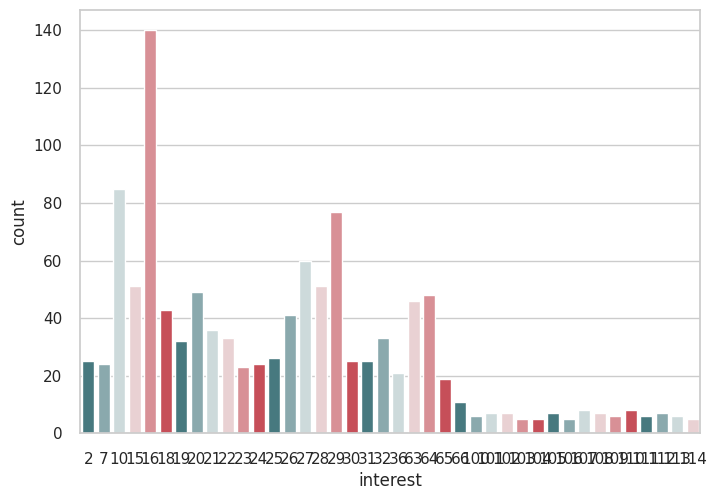

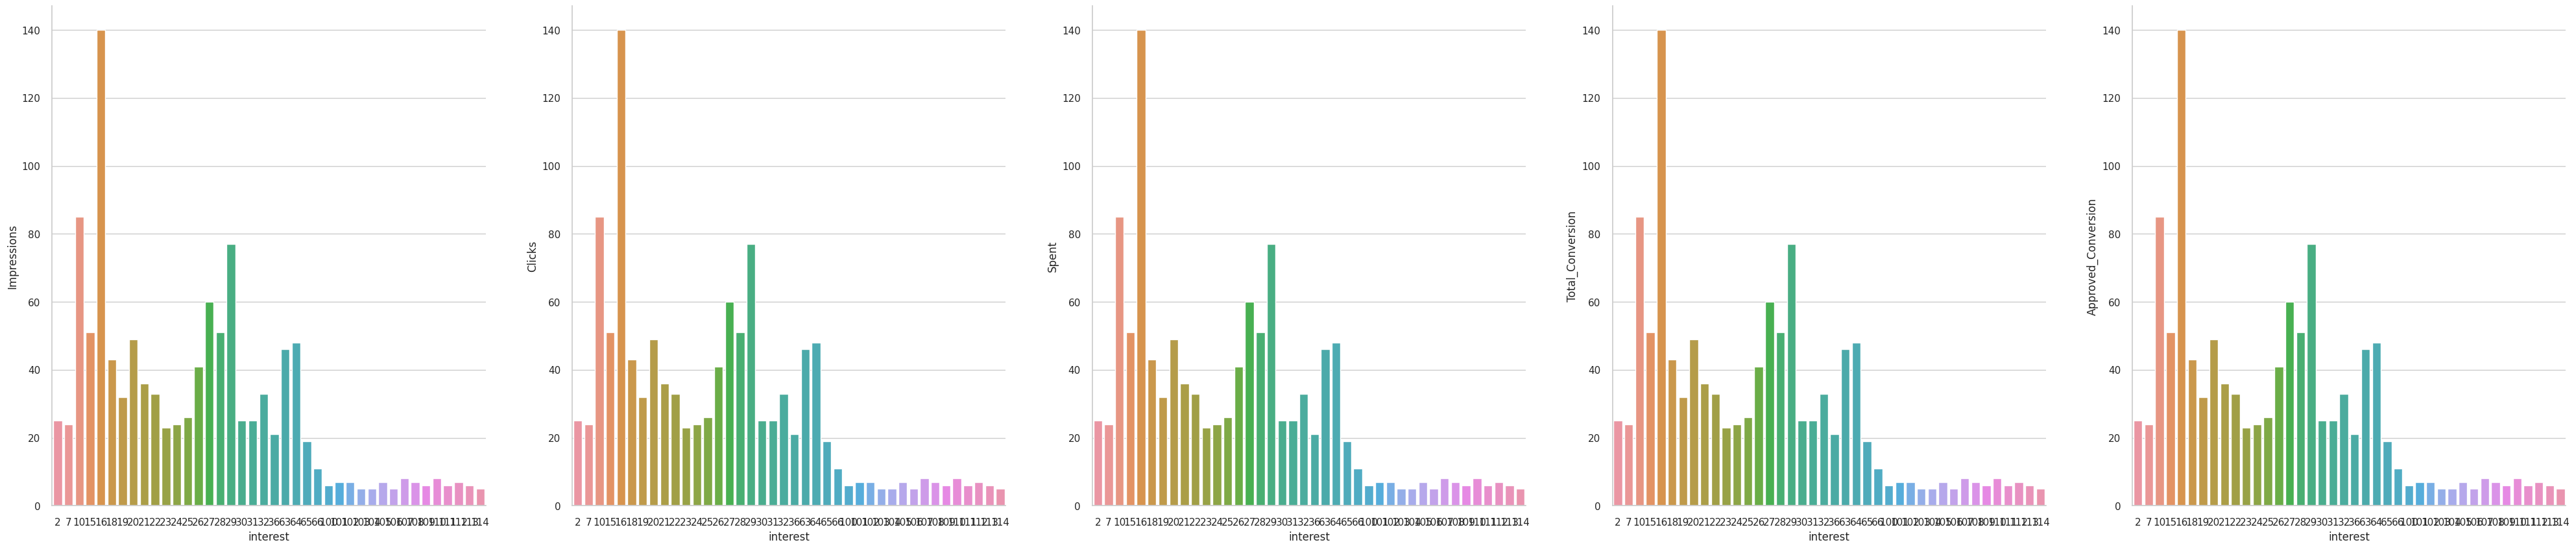

In [ ]:
uni_eda("interest", "cat", agg='count', palette=sns.diverging_palette(203.5, 9.5))

It is worthnoting that the interest 100-114 is more focused on despite that their amount is less compare to other interests.

+--------+
|interest|
+--------+
|      31|
|      65|
|     108|
|     101|
|      28|
|      27|
|      26|
|     103|
|      22|
|     111|
|      16|
|      20|
|      19|
|      64|
|      15|
|     112|
|     107|
|     114|
|     100|
|      23|
+--------+
only showing top 20 rows

+--------+--------+
|interest|count(1)|
+--------+--------+
|      31|      25|
|      65|      19|
|     108|       7|
|     101|       7|
|      28|      51|
|      27|      60|
|      26|      41|
|     103|       5|
|      22|      33|
|     111|       6|
|      16|     140|
|      20|      49|
|      19|      32|
|      64|      48|
|      15|      51|
|     112|       7|
|     107|       8|
|     114|       5|
|     100|       6|
|      23|      23|
+--------+--------+
only showing top 20 rows

+--------+------------------+------------------+------------------+------------------+-------------------+
|interest|       Impressions|            Clicks|             Spent|  Total_conversion|Approved_co

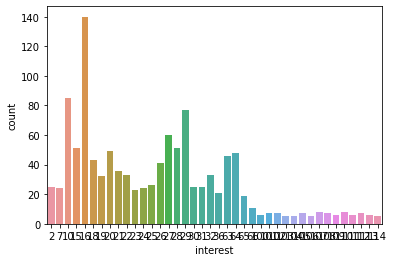

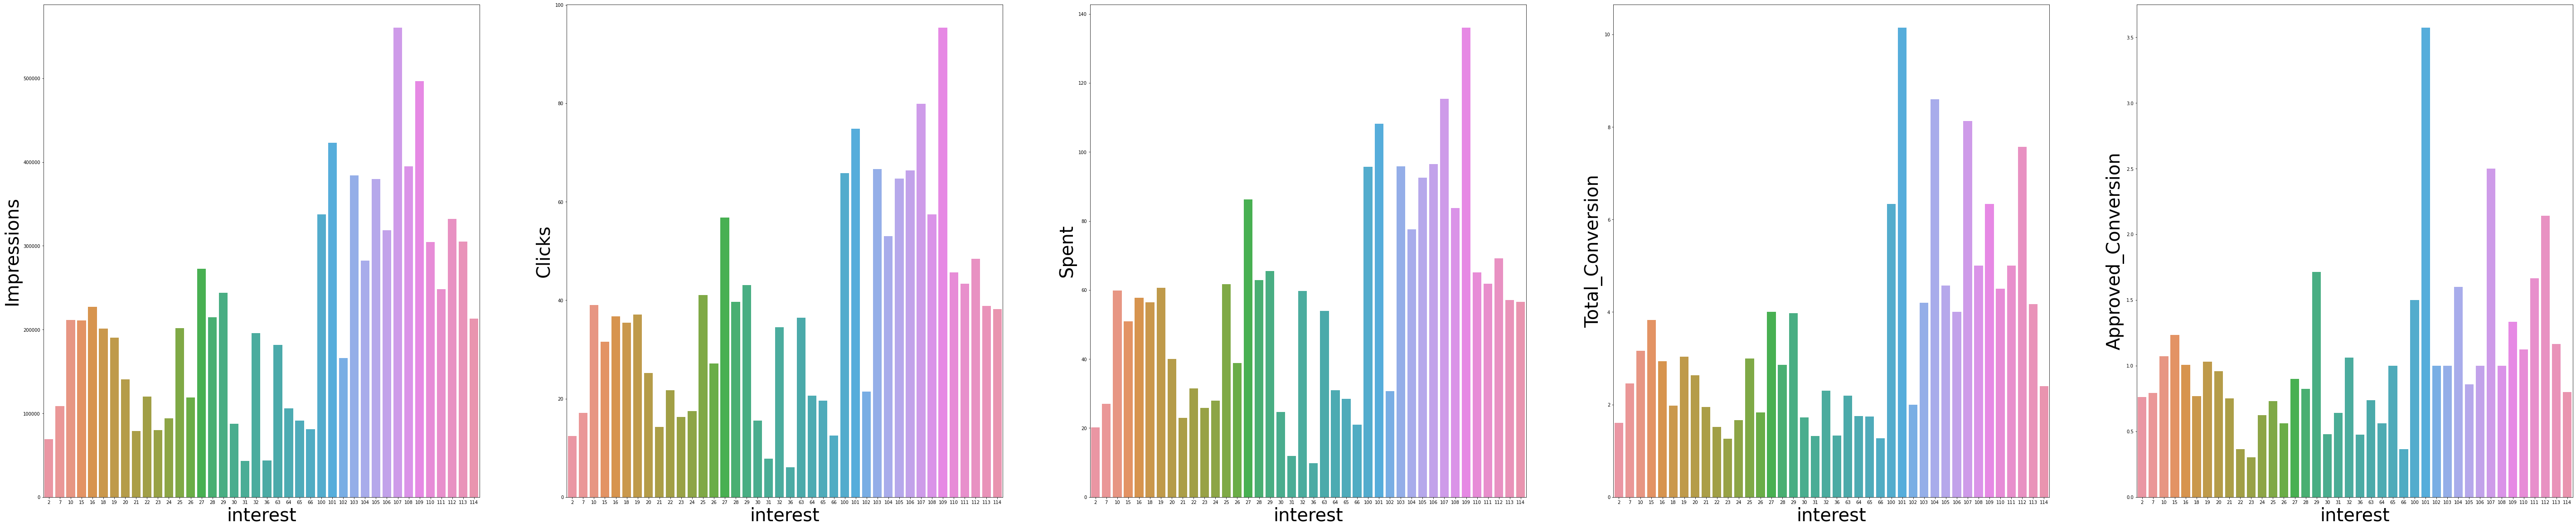

In [ ]:
uni_eda("interest", "cat", agg='avg')

## Spent

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


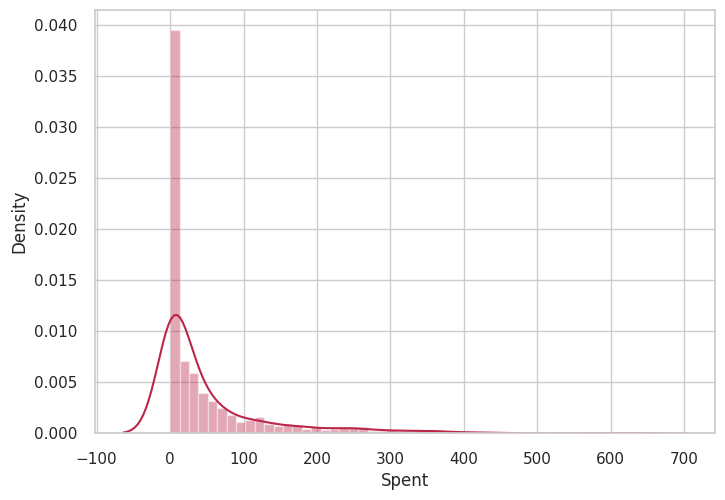

In [ ]:
sns.set_style("whitegrid")
sns.distplot(a=df.toPandas()['Spent'], hist=True, kde=True, rug=False, norm_hist=True, color="#BB2649")
plt.savefig("spent_uni.png")

## Correlogram

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seab

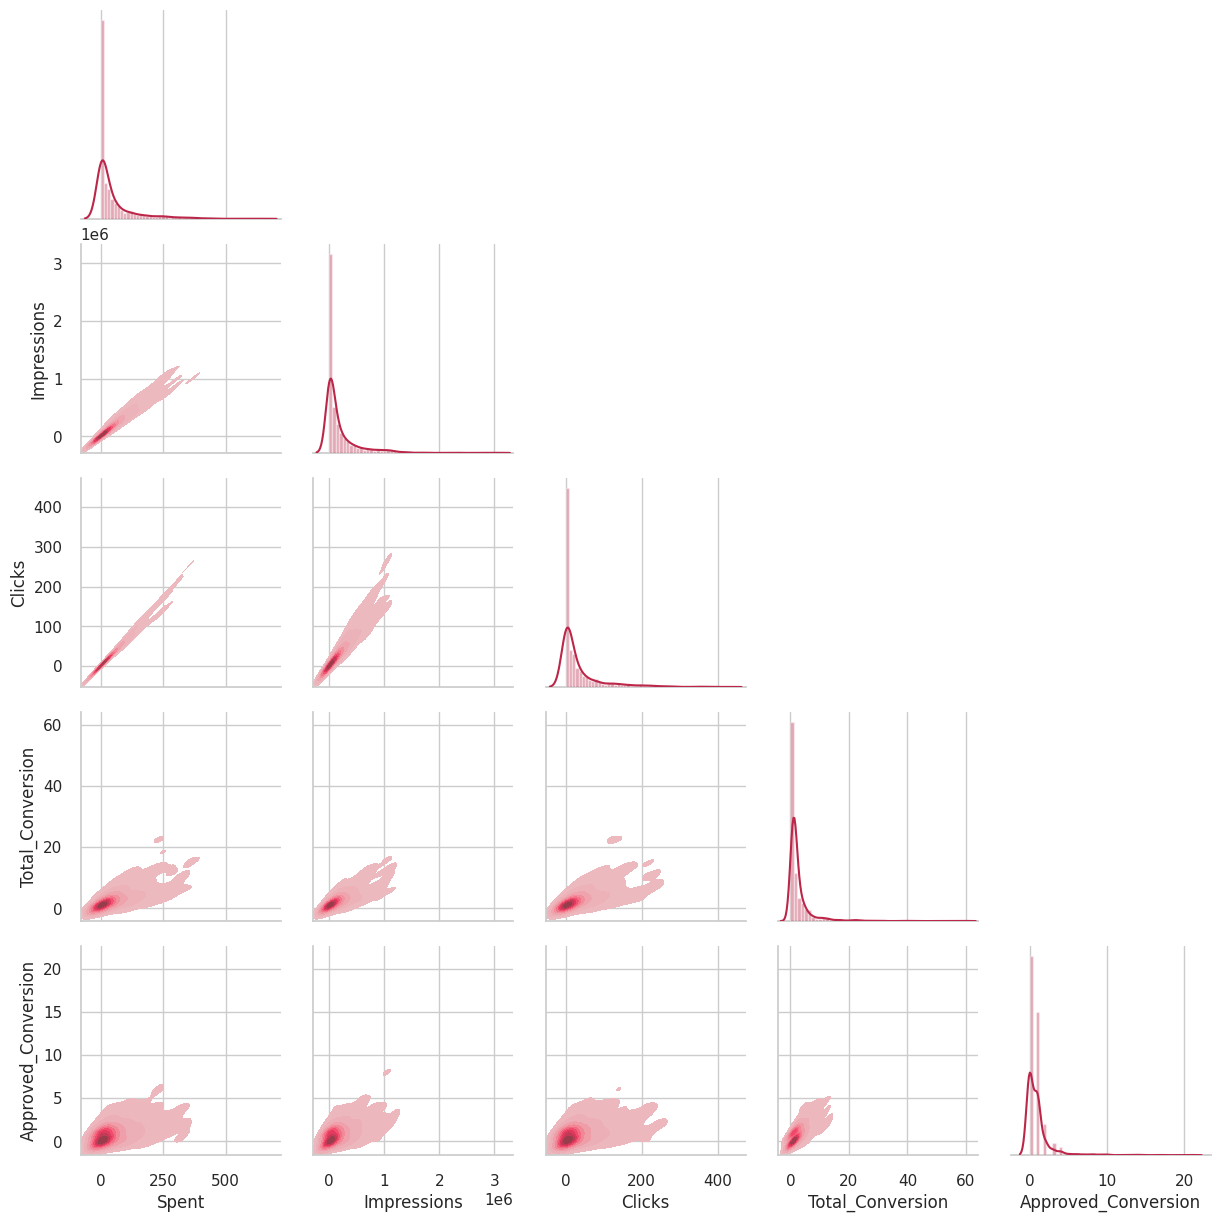

In [ ]:
g=sns.PairGrid(df.toPandas(), vars=['Spent', 'Impressions', 'Clicks', 'Total_Conversion', 'Approved_Conversion'], diag_sharey=False, corner=True)
def lower(*args, **kwargs):
    kwargs['color'] = "#BB2649"
    sns.kdeplot(*args, fill=True, **kwargs)
def diag(*args, **kwargs):
    kwargs['color'] = "#BB2649"
    sns.distplot(*args, hist=True, kde=True, rug=False, norm_hist=True, **kwargs)
g.map_lower(lower)
g.map_diag(diag)
plt.savefig("correl.png")

# EDA: Regression Analysis

In this section, we do some regression analysis to see how dependent variables depends on indepent variables. So far, we have the following independent variables:


*   xyz_campaign_id
*   age
*   gender
*   interest
*   Spent

The dependent variables are:



*   Impressions
*   Clicks
*   Total_Conversion
*   Approved_Conversion







In [ ]:
from pyspark.ml.feature import StringIndexer

stringIndexer = StringIndexer(inputCols=['age', 'gender'], outputCols=['new_age', 'new_gender'])
# Applying stringindexer object on dataframe movie title column
model  = stringIndexer.fit(df)
# Creating new dataframe with transformed values
indexed_df = model.transform(df)
# Validate the numerical title values
indexed_df.show(5)

+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+-------+----------+
| ad_id|xyz_campaign_id|fb_campaign_id|  age|gender|interest|Impressions|Clicks|      Spent|Total_Conversion|Approved_Conversion|new_age|new_gender|
+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+-------+----------+
|708746|            916|        103916|30-34|     M|      15|       7350|     1|1.429999948|               2|                  1|    0.0|       0.0|
|708749|            916|        103917|30-34|     M|      16|      17861|     2|1.820000023|               2|                  0|    0.0|       0.0|
|708771|            916|        103920|30-34|     M|      20|        693|     0|        0.0|               1|                  0|    0.0|       0.0|
|708815|            916|        103928|30-34|     M|      28|       4259|     1|       1.25|              

In [ ]:
from pyspark.ml.feature import VectorAssembler

numericCols = ['xyz_campaign_id', 'new_age', 'new_gender', 'interest', 'Spent']
assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
indexed_df = assembler.transform(indexed_df)
indexed_df.show()

+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+-------+----------+--------------------+
| ad_id|xyz_campaign_id|fb_campaign_id|  age|gender|interest|Impressions|Clicks|      Spent|Total_Conversion|Approved_Conversion|new_age|new_gender|            features|
+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+-------+----------+--------------------+
|708746|            916|        103916|30-34|     M|      15|       7350|     1|1.429999948|               2|                  1|    0.0|       0.0|[916.0,0.0,0.0,15...|
|708749|            916|        103917|30-34|     M|      16|      17861|     2|1.820000023|               2|                  0|    0.0|       0.0|[916.0,0.0,0.0,16...|
|708771|            916|        103920|30-34|     M|      20|        693|     0|        0.0|               1|                  0|    0.0|       0.0|(5

In [ ]:
train, test = indexed_df.randomSplit([0.8, 0.2], seed = 0)

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
import pyspark.sql.functions as func
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

## Reputation Variables

### Impressions

In [ ]:
rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'Impressions', seed=42)
rfevaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Impressions",metricName="r2")


paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10]).build()
                              # .addGrid(rf.minInstancesPerNode, [1, 2, 4]) \
                              # .addGrid(rf.maxDepth, [5, 10]) \
                              # .build()

crossval = CrossValidator(estimator = rf,
                      estimatorParamMaps = paramGrid,
                      evaluator = rfevaluator,
                      numFolds = 5)

cvModel = crossval.fit(train)

predictions = cvModel.transform(test)

In [ ]:
rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'Impressions', numTrees=10, maxDepth=10, seed=42)
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions = predictions.withColumn("prediction", func.round(predictions["prediction"], 0))

In [ ]:
predictions = predictions.withColumn("prediction", func.round(predictions["prediction"], 0))
r2 = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Impressions",metricName="r2")
print("R Squared (R2) on test data = %g" % r2.evaluate(predictions))

R Squared (R2) on test data = 0.964322


In [ ]:
rfModel.featureImportances

SparseVector(5, {0: 0.0786, 1: 0.0394, 2: 0.0131, 3: 0.0335, 4: 0.8353})

In [ ]:
list(zip(numericCols, rfModel.featureImportances))

[('xyz_campaign_id', 0.07864057915071321),
 ('new_age', 0.03938889763516438),
 ('new_gender', 0.01312652739551008),
 ('interest', 0.03351253662183863),
 ('Spent', 0.8353314591967737)]

We can clearly see that Spent have the most effect on Impressions.

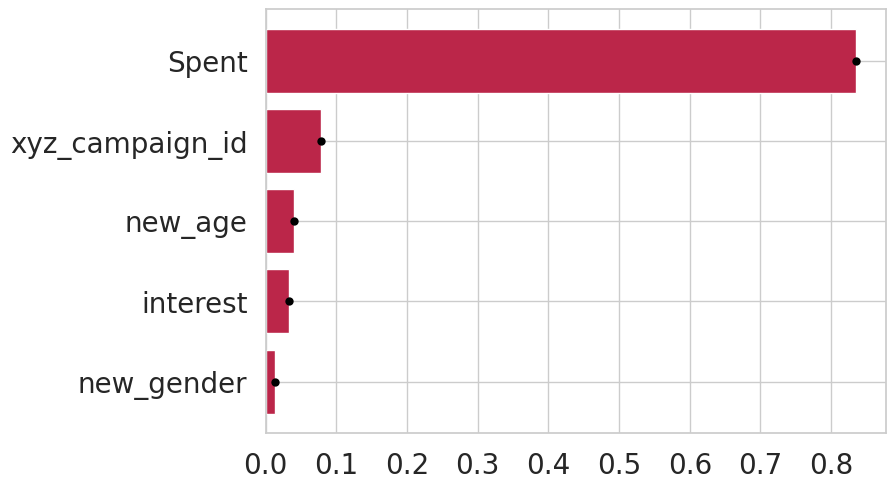

In [ ]:
import numpy as np
importance = pd.DataFrame(list(zip(numericCols, rfModel.featureImportances)))
importance = importance.sort_values([1], ascending=True).reset_index(drop=True)

height = importance[1]
bars = importance[0]
y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, height, color='#bb2649')
 
# Create names on the x-axis
plt.yticks(y_pos, bars)

# Reorder it based on the values
my_range=importance[0]
 
# The horizontal plot is made using the hline function
# plt.hlines(y=my_range, xmin=0, xmax=importance[1], color='#bb2649', linewidth='4')
plt.plot(importance[1], my_range, "o", color='black')

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# plt.savefig("Impression_importance.png")

### Clicks

In [ ]:
rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'Clicks', numTrees=50, maxDepth=20, seed=42)
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions = predictions.withColumn("prediction", func.round(predictions["prediction"], 0))

In [ ]:
predictions = predictions.withColumn("prediction", func.round(predictions["prediction"], 0))
r2 = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Clicks",metricName="r2")
print("R Squared (R2) on test data = %g" % r2.evaluate(predictions))

R Squared (R2) on test data = 0.978314


In [ ]:
list(zip(numericCols, rfModel.featureImportances))

[('xyz_campaign_id', 0.1192289421260943),
 ('new_age', 0.028149120404000267),
 ('new_gender', 0.033557320709134544),
 ('interest', 0.035102220630379356),
 ('Spent', 0.7839623961303913)]

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 <a list of 10 Text major ticklabel objects>)

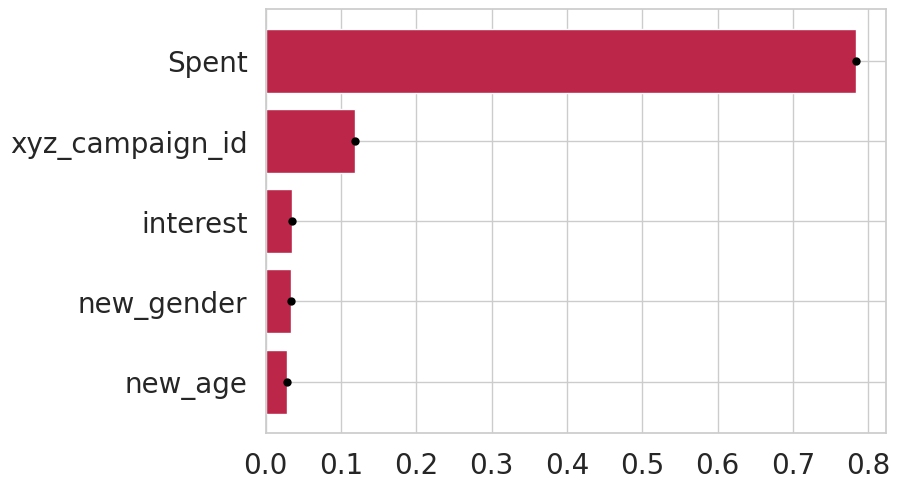

In [ ]:
import numpy as np
importance = pd.DataFrame(list(zip(numericCols, rfModel.featureImportances)))
importance = importance.sort_values([1], ascending=True).reset_index(drop=True)

height = importance[1]
bars = importance[0]
y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, height, color='#bb2649')
 
# Create names on the x-axis
plt.yticks(y_pos, bars)

# Reorder it based on the values
my_range=importance[0]
 
# The horizontal plot is made using the hline function
# plt.hlines(y=my_range, xmin=0, xmax=importance[1], color='#bb2649', linewidth='4')
plt.plot(importance[1], my_range, "o", color='black')

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

We can clearly see that Spent have the most effect on Clicks.

## Sales Conversion

### Total Conversion

In [ ]:
rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'Total_Conversion', numTrees=10, maxDepth=10, seed=42)
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions = predictions.withColumn("prediction", func.round(predictions["prediction"], 0))

In [ ]:
predictions = predictions.withColumn("prediction", func.round(predictions["prediction"], 0))
r2 = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Total_Conversion",metricName="r2")
print("R Squared (R2) on test data = %g" % r2.evaluate(predictions))

R Squared (R2) on test data = 0.701334


In [ ]:
rfModel.featureImportances

SparseVector(5, {0: 0.0552, 1: 0.16, 2: 0.0342, 3: 0.1598, 4: 0.5908})

In [ ]:
list(zip(numericCols, rfModel.featureImportances))

[('xyz_campaign_id', 0.055172420324036464),
 ('new_age', 0.16000407294302185),
 ('new_gender', 0.03420567322623615),
 ('interest', 0.15981322115417285),
 ('Spent', 0.5908046123525325)]

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]),
 <a list of 8 Text major ticklabel objects>)

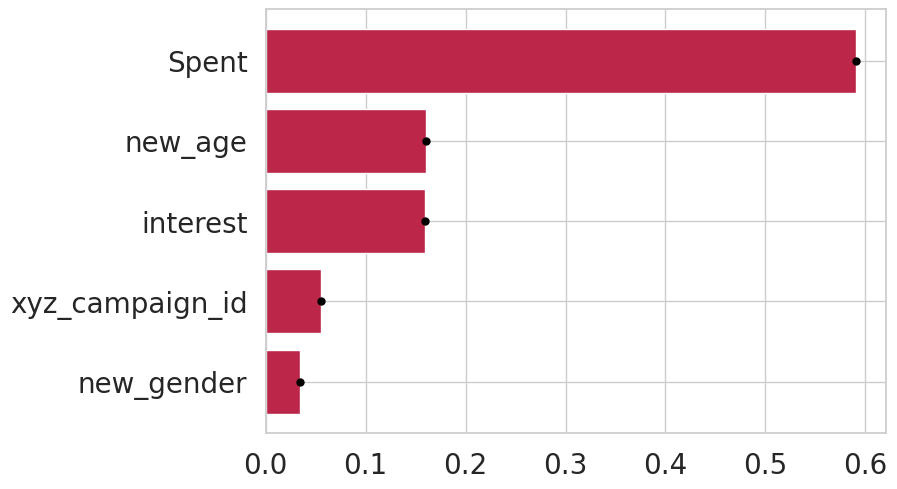

In [ ]:
import numpy as np
importance = pd.DataFrame(list(zip(numericCols, rfModel.featureImportances)))
importance = importance.sort_values([1], ascending=True).reset_index(drop=True)

height = importance[1]
bars = importance[0]
y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, height, color='#bb2649')
 
# Create names on the x-axis
plt.yticks(y_pos, bars)

# Reorder it based on the values
my_range=importance[0]
 
# The horizontal plot is made using the hline function
# plt.hlines(y=my_range, xmin=0, xmax=importance[1], color='#bb2649', linewidth='4')
plt.plot(importance[1], my_range, "o", color='black')

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

### Approved Conversion

In [ ]:
rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'Approved_Conversion', numTrees=20, maxDepth=20, seed=42)
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions = predictions.withColumn("prediction", func.round(predictions["prediction"], 0))

In [ ]:
predictions = predictions.withColumn("prediction", func.round(predictions["prediction"], 0))
r2 = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Approved_Conversion",metricName="r2")
print("R Squared (R2) on test data = %g" % r2.evaluate(predictions))

R Squared (R2) on test data = 0.536858


In [ ]:
rfModel.featureImportances

SparseVector(5, {0: 0.0569, 1: 0.1805, 2: 0.0706, 3: 0.211, 4: 0.481})

In [ ]:
list(zip(numericCols, rfModel.featureImportances))

[('xyz_campaign_id', 0.05688863029214454),
 ('new_age', 0.1804651153673665),
 ('new_gender', 0.0706081323147916),
 ('interest', 0.21103882552221037),
 ('Spent', 0.480999296503487)]

# Algorithm 1: Personalized Spent for each group of customers 

As stated above that among independent variables, Spent dominates the effects on Clicks and Impressions. Thus, in this section, we model the usecase as follow:


*   Given a range of budget, find the point that can balance between maximize the Clicks and minimize the 




## Train a function to map the setting spaces to clicks

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
import pyspark.sql.functions as func
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [ ]:
from pyspark.ml.feature import StringIndexer

stringIndexer = StringIndexer(inputCols=['age', 'gender'], outputCols=['new_age', 'new_gender'])
# Applying stringindexer object on dataframe movie title column
model  = stringIndexer.fit(df)
# Creating new dataframe with transformed values
indexed_df = model.transform(df)
# Validate the numerical title values
indexed_df.show(5)

+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+-------+----------+
| ad_id|xyz_campaign_id|fb_campaign_id|  age|gender|interest|Impressions|Clicks|      Spent|Total_Conversion|Approved_Conversion|new_age|new_gender|
+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+-------+----------+
|708746|            916|        103916|30-34|     M|      15|       7350|     1|1.429999948|               2|                  1|    0.0|       0.0|
|708749|            916|        103917|30-34|     M|      16|      17861|     2|1.820000023|               2|                  0|    0.0|       0.0|
|708771|            916|        103920|30-34|     M|      20|        693|     0|        0.0|               1|                  0|    0.0|       0.0|
|708815|            916|        103928|30-34|     M|      28|       4259|     1|       1.25|              

In [ ]:
from pyspark.ml.feature import VectorAssembler

numericCols = ['xyz_campaign_id', 'new_age', 'new_gender', 'interest', 'Spent']
assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
indexed_df = assembler.transform(indexed_df)
indexed_df.show()

+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+-------+----------+--------------------+
| ad_id|xyz_campaign_id|fb_campaign_id|  age|gender|interest|Impressions|Clicks|      Spent|Total_Conversion|Approved_Conversion|new_age|new_gender|            features|
+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+-------+----------+--------------------+
|708746|            916|        103916|30-34|     M|      15|       7350|     1|1.429999948|               2|                  1|    0.0|       0.0|[916.0,0.0,0.0,15...|
|708749|            916|        103917|30-34|     M|      16|      17861|     2|1.820000023|               2|                  0|    0.0|       0.0|[916.0,0.0,0.0,16...|
|708771|            916|        103920|30-34|     M|      20|        693|     0|        0.0|               1|                  0|    0.0|       0.0|(5

In [ ]:
train, val = indexed_df.randomSplit([0.8, 0.2], seed = 0)

In [ ]:
rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'Clicks',  numTrees=50, maxDepth=20, seed=42)
rfModel = rf.fit(train)
predictions = rfModel.transform(val)
predictions = predictions.withColumn("prediction", func.round(predictions["prediction"], 0))

In [ ]:
predictions = predictions.withColumn("prediction", func.round(predictions["prediction"], 0))
r2 = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Clicks",metricName="r2")
print("R Squared (R2) on test data = %g" % r2.evaluate(predictions))

R Squared (R2) on test data = 0.978314


In [ ]:
def map_click(setting, budget, predictor):
    test_pd = pd.DataFrame({
      'xyz_campaign_id': [setting['xyz_campaign_id']]*len(budget),
    
      'age': [setting['age']]*len(budget),
    
      'gender': [setting['gender']]*len(budget),
    
      'interest': [setting['interest']]*len(budget),
    
      'Spent': budget
      })
    
    test = spark.createDataFrame(test_pd)
    
    numericCols = ['xyz_campaign_id', 'age', 'gender', 'interest', 'Spent']
    assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
    test = assembler.transform(test)

    predictions = predictor.transform(test)
    predictions = predictions.withColumn("prediction", func.round(predictions["prediction"], 0))

    sns.set_style("white")
    sns.lineplot(data=predictions.toPandas(), x="Spent", y="prediction", color="#bb2649")

    test.createOrReplaceTempView("test")

    my_window = Window.partitionBy().orderBy("Spent")

    predictions = predictions.withColumn("prev_prediction", F.lag(predictions.prediction).over(my_window))
    predictions = predictions.withColumn("diff", F.when(F.isnull(predictions.prediction - predictions.prev_prediction), 0)
                                  .otherwise(predictions.prediction - predictions.prev_prediction))
    
    predictions.createOrReplaceTempView("predictions")
    res = spark.sql("SELECT Spent, prediction, diff FROM predictions WHERE diff = (SELECT MAX(diff) FROM predictions)")
    res.show()

    return res.collect()[0]['Spent']




+-----+----------+-----+
|Spent|prediction| diff|
+-----+----------+-----+
|  292|     198.0|105.0|
+-----+----------+-----+



292

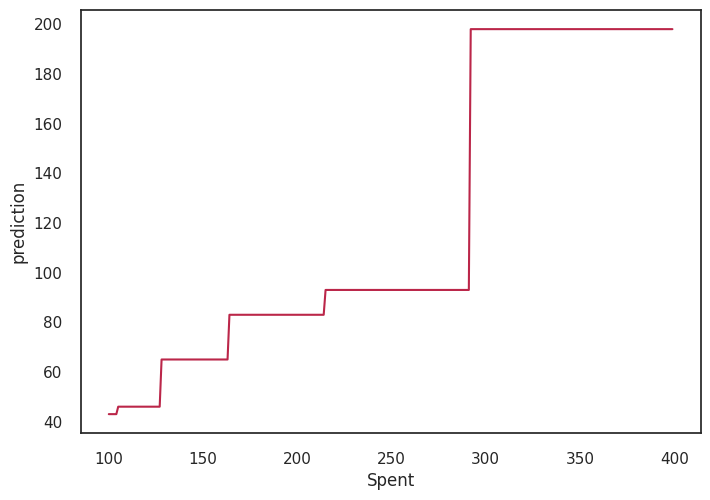

In [ ]:
setting = {'xyz_campaign_id': 916.0,
           'age': 0.0,
           'gender': 0.0,
           'interest': 15}
budget = [i for i in range(100,400,1)]
map_click(setting, budget, rfModel)

# Feature Engineering


## Adding conversions features

From the sanity checks and the optimization problem, we define 4 additional feature as follow:



*   Spent per Click: Cost per Click (CPC)
*   Click per Impression: Click through rate (CTR)
*   Total/Approved Conversion per Impression ((A)CR)
*   Approved Conversion per Total Conversion (AR)

We also want to include the cost per conversion, however some spent = 0 yet having positive conversion, so we did not include this measure.





In [ ]:
df = df.withColumn('CPC', df['Spent'] / df['Clicks'])
df = df.withColumn('CTR', df['Clicks']*100 / df['Impressions'])
df = df.withColumn('TCR', df['Total_Conversion']*100 / df['Impressions'])
df = df.withColumn('ACR', df['Approved_Conversion']*100 / df['Impressions'])
df = df.withColumn('AR', df['Approved_Conversion']*100 / df['Total_Conversion'])

In [ ]:
df=df.na.fill(value=10,subset=["CPC"])

In [ ]:
df.createOrReplaceTempView("df")

In [ ]:
df.show(10)

+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+------------------+--------------------+--------------------+--------------------+-----+
| ad_id|xyz_campaign_id|fb_campaign_id|  age|gender|interest|Impressions|Clicks|      Spent|Total_Conversion|Approved_Conversion|               CPC|                 CTR|                 TCR|                 ACR|   AR|
+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+------------------+--------------------+--------------------+--------------------+-----+
|708746|            916|        103916|30-34|     M|      15|       7350|     1|1.429999948|               2|                  1|       1.429999948|0.013605442176870748|0.027210884353741496|0.013605442176870748| 50.0|
|708749|            916|        103917|30-34|     M|      16|      17861|     2|1.820000023|               2|                  0

## EDA for addiontal features

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

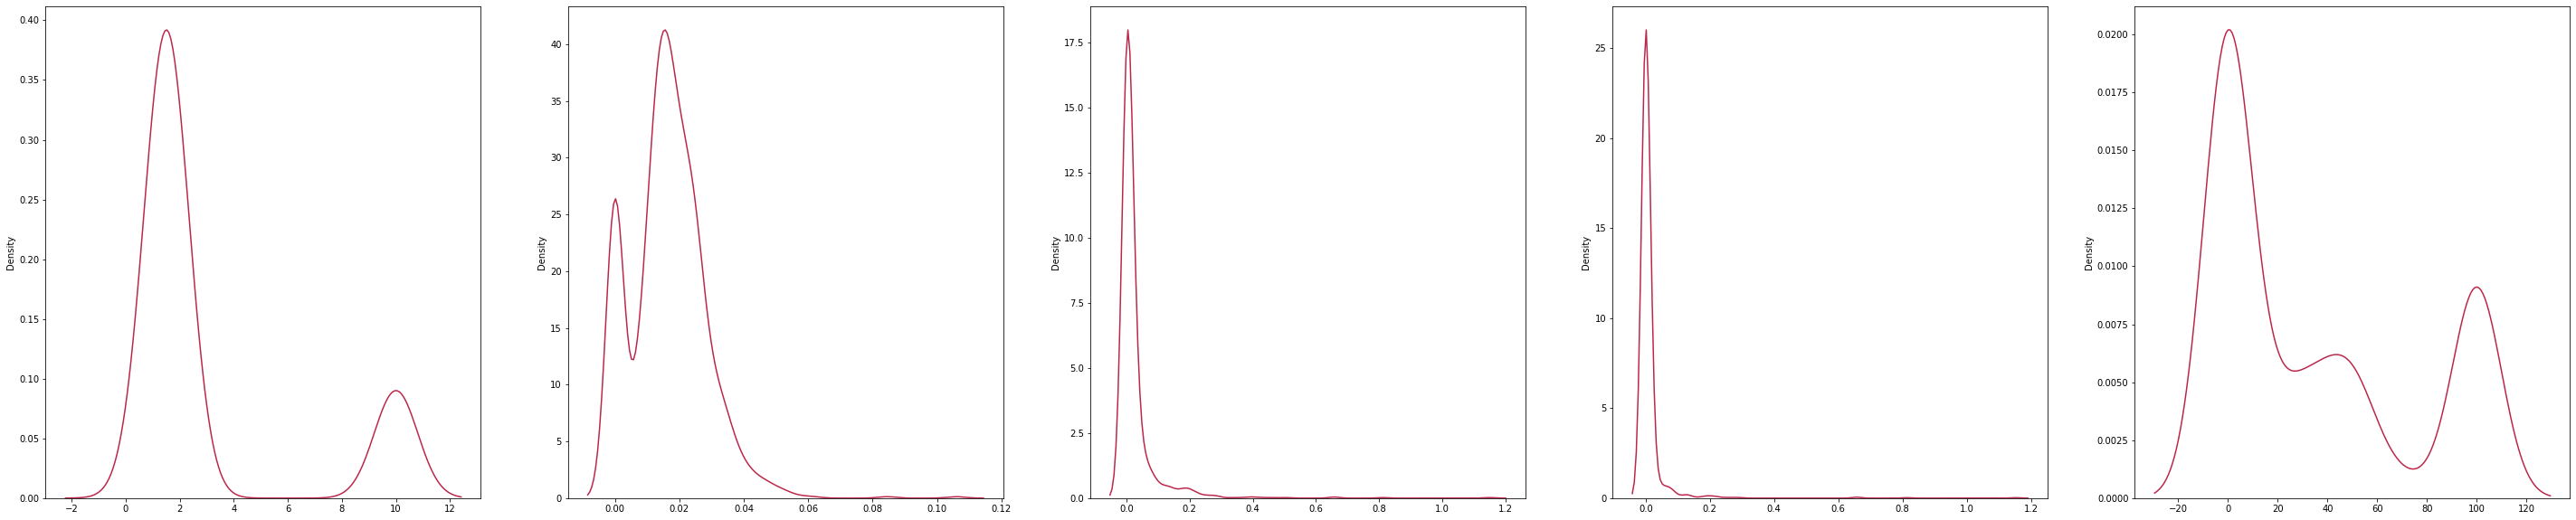

In [ ]:
labels = []
i = 0
fig, axs = plt.subplots(1, 5, figsize=(50, 10))
for feat in ['CPC', 'CTR', 'TCR', 'ACR', 'AR']:
  x = spark.sql("SELECT {0} \
            FROM df".format(feat)).toPandas()
  labels.append(feat)
  sns.distplot(a=x, hist=False, kde=True, norm_hist=True, ax=axs[i], color='#BB2649')
  i += 1

From the general density, we can see that the 'CTR' and 'AR' can be clustered. Next, we break down the data to the independent variables

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

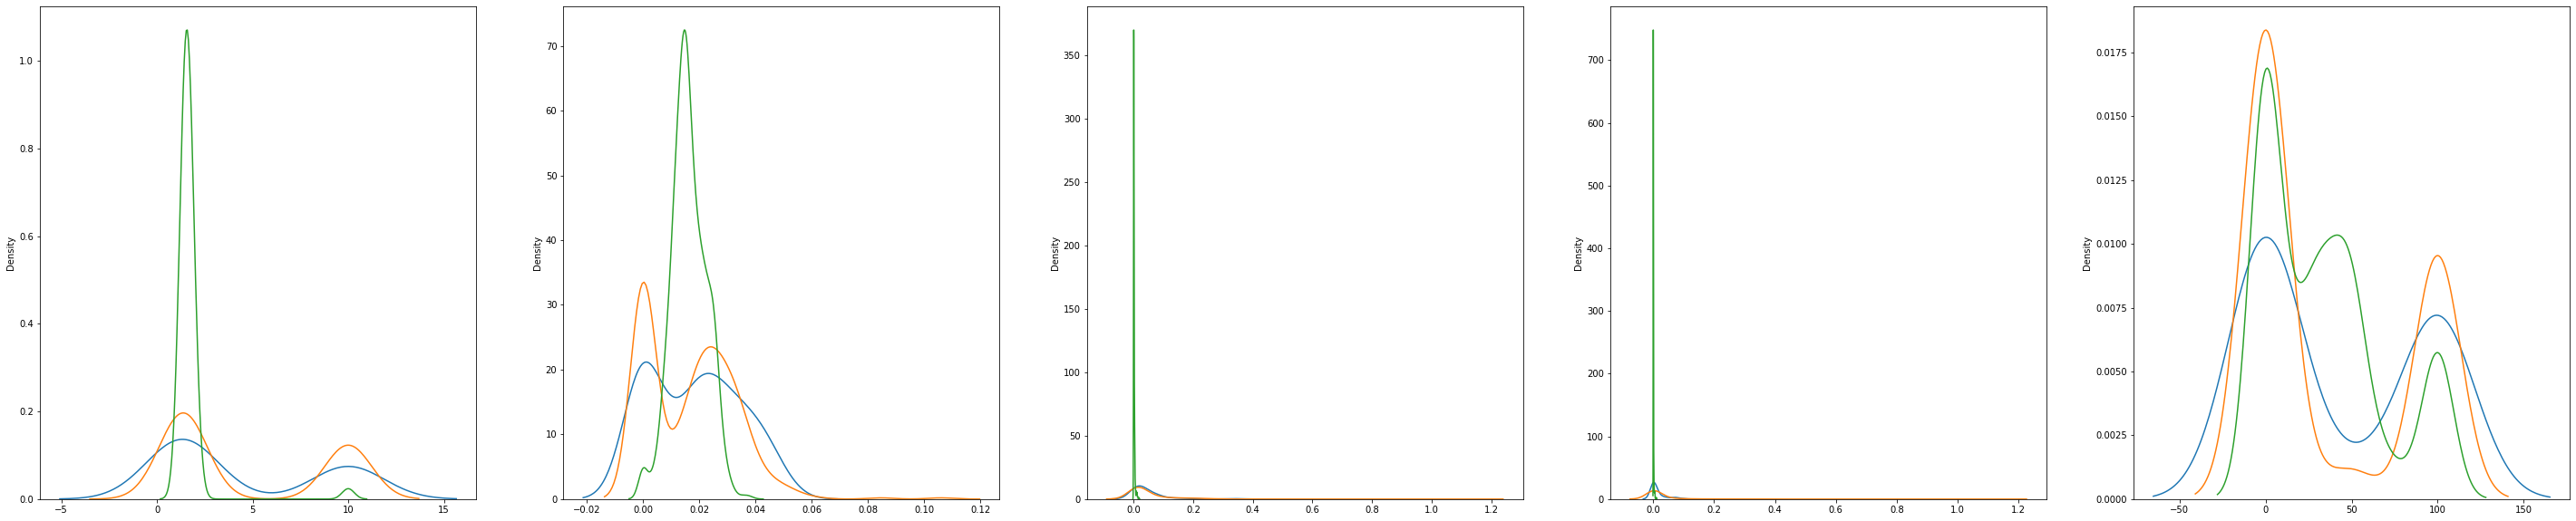

In [ ]:
labels = []
i = 0
fig, axs = plt.subplots(1, 5, figsize=(50, 10))
for feat in ['CPC', 'CTR', 'TCR', 'ACR', 'AR']:
  for cp in ['916', '936', '1178']:
    x = spark.sql("SELECT {0} \
              FROM df \
              WHERE xyz_campaign_id = '{1}'".format(feat, cp)).toPandas()
    sns.distplot(a=x, hist=False, kde=True, ax=axs[i])
  i += 1

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

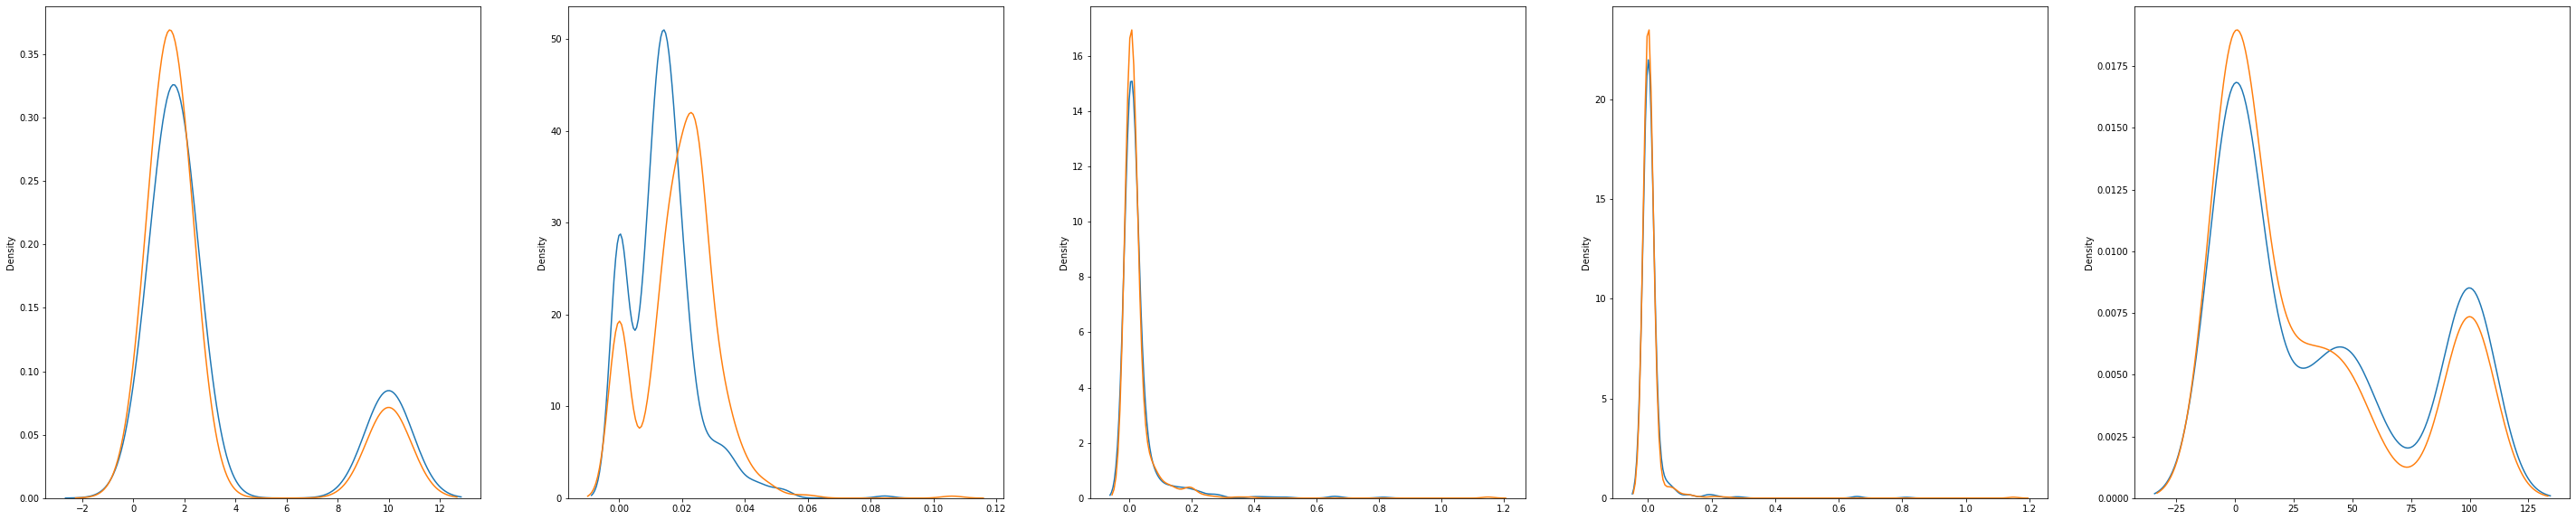

In [ ]:
labels = []
i = 0
fig, axs = plt.subplots(1, 5, figsize=(50, 10))
for feat in ['CPC', 'CTR', 'TCR', 'ACR', 'AR']:
  for gender in ['M', 'F']:
    x = spark.sql("SELECT {0} \
              FROM df \
              WHERE GENDER = '{1}'".format(feat, gender)).toPandas()
    sns.distplot(a=x, hist=False, kde=True, ax=axs[i])
  i += 1

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

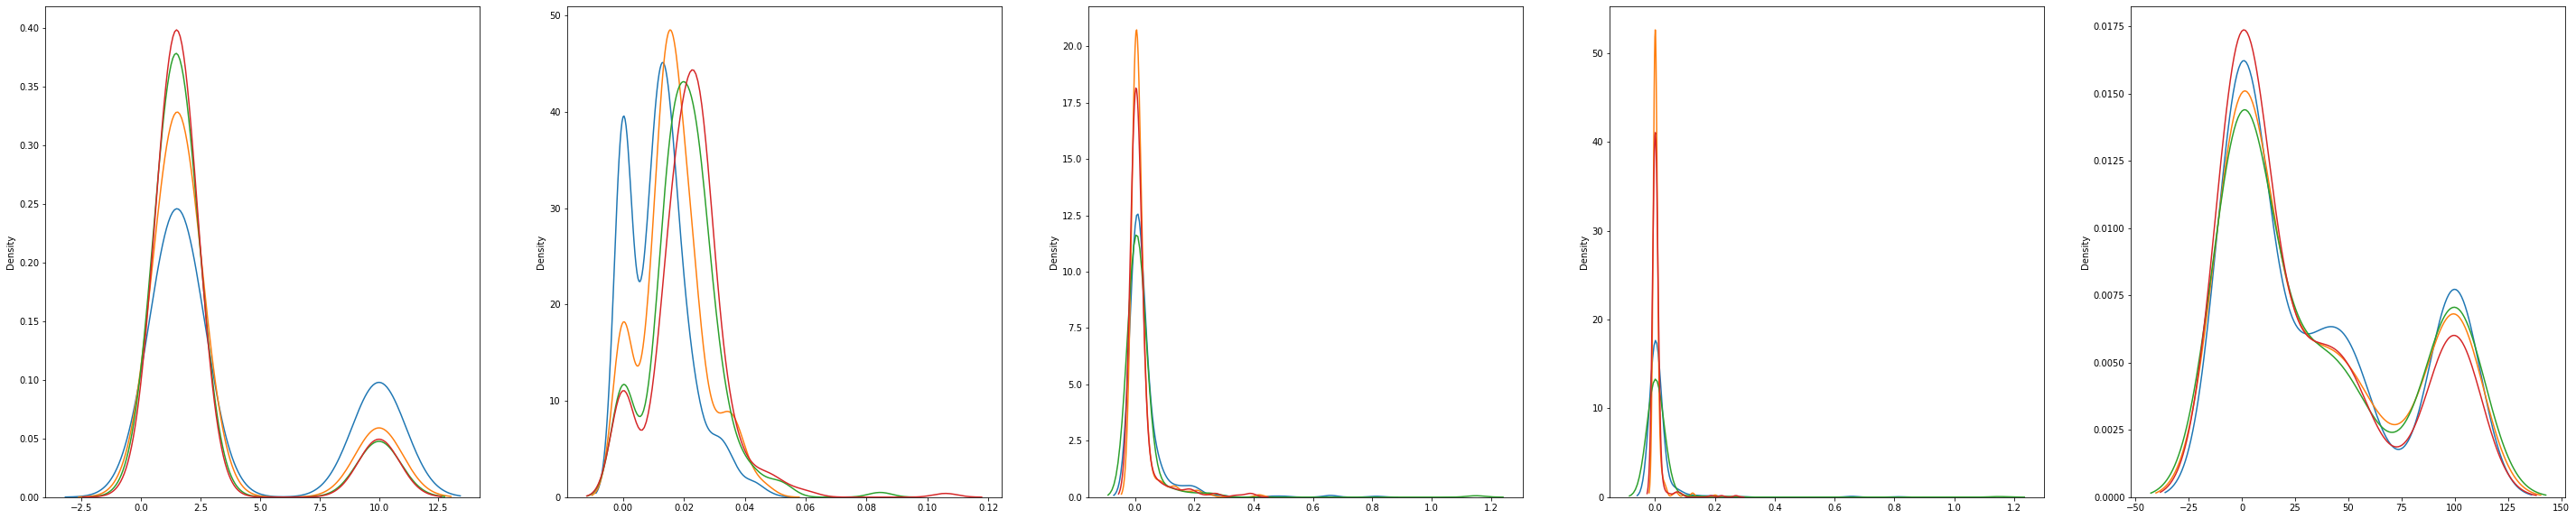

In [ ]:
labels = []
i = 0
fig, axs = plt.subplots(1, 5, figsize=(50, 10))
for feat in ['CPC', 'CTR', 'TCR', 'ACR', 'AR']:
  for age in ['30-34', '35-39', '40-44', '45-49']:
    x = spark.sql("SELECT {0} \
              FROM df \
              WHERE AGE = '{1}'".format(feat, age)).toPandas()
    sns.distplot(a=x, hist=False, kde=True, ax=axs[i])
  i += 1

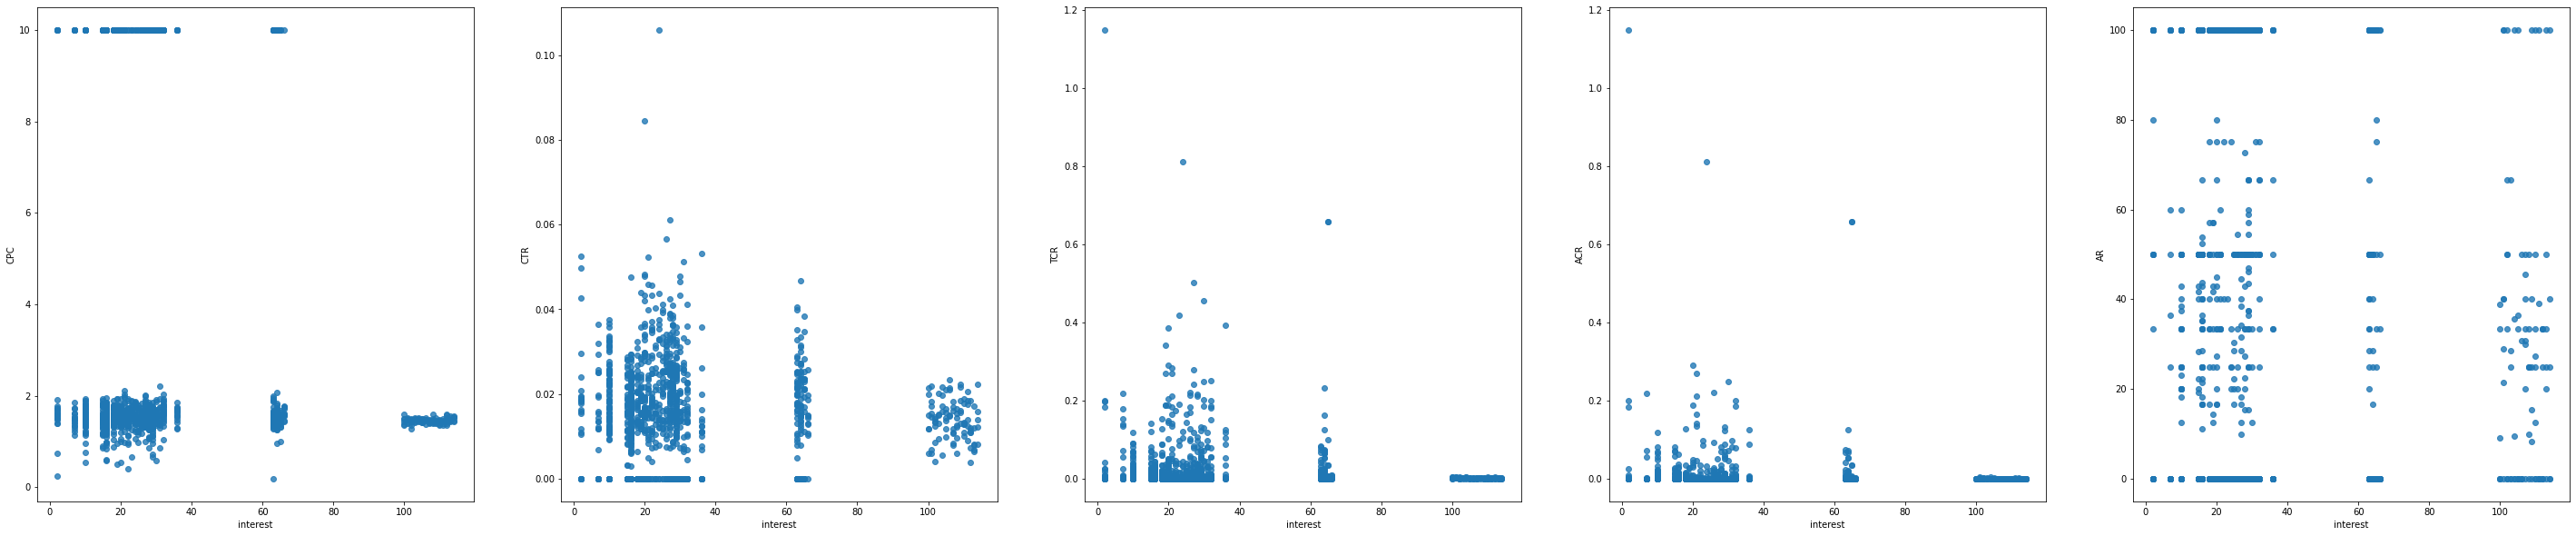

In [ ]:
labels = []
i = 0
fig, axs = plt.subplots(1, 5, figsize=(50, 10))
for feat in ['CPC', 'CTR', 'TCR', 'ACR', 'AR']:
  labels.append(feat)
  sns.regplot(y=df.toPandas()[feat], x=df.toPandas()["interest"], ax=axs[i],fit_reg=False)
  i += 1

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seab

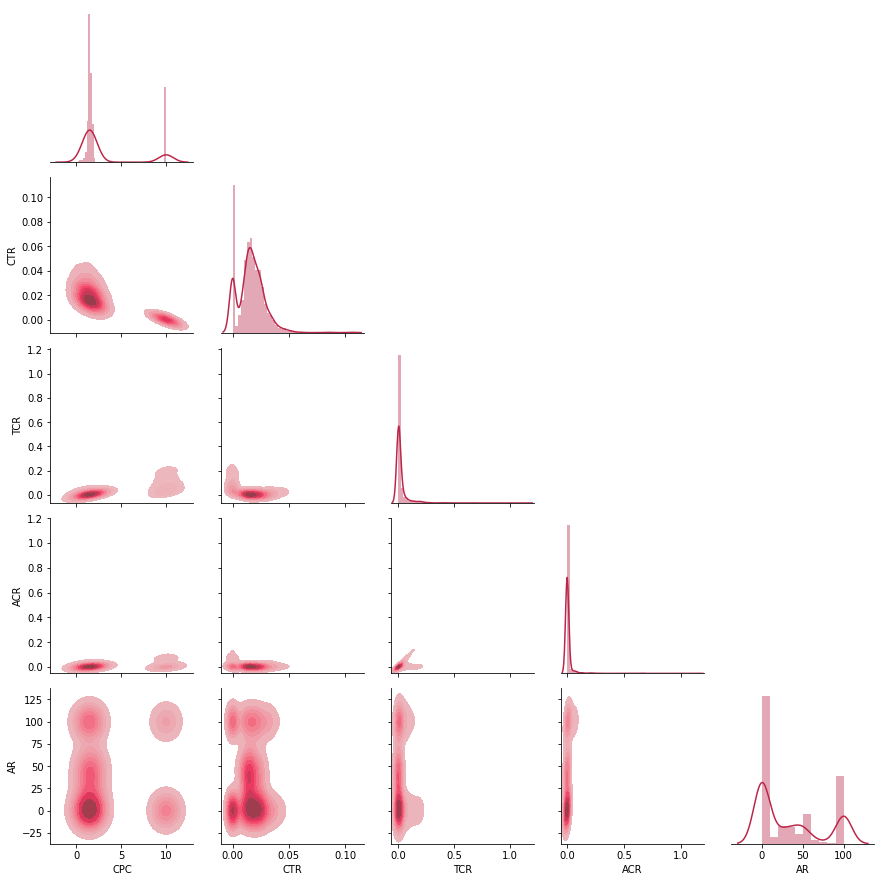

In [ ]:
g=sns.PairGrid(df.toPandas(), vars=['CPC', 'CTR', 'TCR', 'ACR', 'AR'], diag_sharey=False, corner=True)
def lower(*args, **kwargs):
    kwargs['color'] = "#BB2649"
    sns.kdeplot(*args, fill=True, **kwargs)
def diag(*args, **kwargs):
    kwargs['color'] = "#BB2649"
    sns.distplot(*args, hist=True, kde=True, rug=False, norm_hist=True, **kwargs)
g.map_lower(lower)
g.map_diag(diag)
plt.savefig("correl_fe.png")

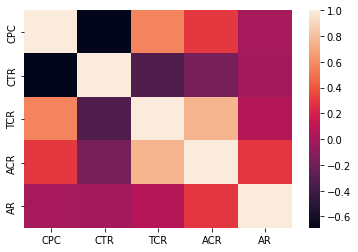

In [ ]:
sns.heatmap(df.select(['CPC', 'CTR', 'TCR', 'ACR', 'AR']).toPandas().corr())

# Algorithm 2: Classifying potential customers

In [ ]:
df_avg = spark.sql("SELECT xyz_campaign_id, fb_campaign_id, age, gender, interest, \
 AVG(CPC) CPC, AVG(CTR) CTR, AVG(TCR) TCR, AVG(ACR) ACR, AVG(AR) AR FROM df GROUP BY xyz_campaign_id, fb_campaign_id, age, gender, interest")

In [ ]:
df_avg.show()

+---------------+--------------+-----+------+--------+------------------+--------------------+--------------------+--------------------+------------------+
|xyz_campaign_id|fb_campaign_id|  age|gender|interest|               CPC|                 CTR|                 TCR|                 ACR|                AR|
+---------------+--------------+-----+------+--------+------------------+--------------------+--------------------+--------------------+------------------+
|           1178|        144558|30-34|     M|      31| 4.534666637333333|0.005916937489302277|0.004178901162029121|6.627168740970484E-4|16.666666666666668|
|           1178|        144630|45-49|     M|      23|1.7526983947222223|0.015786107666691668|0.002385181096414234|                 0.0|               0.0|
|            936|        108826|45-49|     F|      19|              10.0|                 0.0| 0.18867924528301888|                 0.0|               0.0|
|            916|        104109|40-44|     M|      16|1.21000002

## Clustering based on CTR, CPC

We can see that there are 2 modes in the CTR, hence we first bring this to an unsupervised task. We try to cluster the customers into 2 clusters, using (CPC, CTR) which are variables related to sales/revenue.

In [ ]:
from pyspark.ml.feature import VectorAssembler
assemble=VectorAssembler(inputCols=['CPC', 'CTR'], outputCol='features')
assembled_data=assemble.transform(df)

In [ ]:
assembled_data.show()

+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+------------------+--------------------+--------------------+--------------------+-----+--------------------+
| ad_id|xyz_campaign_id|fb_campaign_id|  age|gender|interest|Impressions|Clicks|      Spent|Total_Conversion|Approved_Conversion|               CPC|                 CTR|                 TCR|                 ACR|   AR|            features|
+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+------------------+--------------------+--------------------+--------------------+-----+--------------------+
|708746|            916|        103916|30-34|     M|      15|       7350|     1|1.429999948|               2|                  1|       1.429999948|0.013605442176870748|0.027210884353741496|0.013605442176870748| 50.0|[1.429999948,0.01...|
|708749|            916|        103917|30-34

In [ ]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show()

+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+
| ad_id|xyz_campaign_id|fb_campaign_id|  age|gender|interest|Impressions|Clicks|      Spent|Total_Conversion|Approved_Conversion|               CPC|                 CTR|                 TCR|                 ACR|   AR|            features|        standardized|
+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+
|708746|            916|        103916|30-34|     M|      15|       7350|     1|1.429999948|               2|                  1|       1.429999948|0.013605442176870748|0.027210884353741496|0.013605442176870748| 50.0|[1.

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
    
KMeans_algo=KMeans(featuresCol='standardized', k=2)

KMeans_fit=KMeans_algo.fit(data_scale_output)

output=KMeans_fit.transform(data_scale_output)

score=evaluator.evaluate(output)
    

In [ ]:
output.show()

+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
| ad_id|xyz_campaign_id|fb_campaign_id|  age|gender|interest|Impressions|Clicks|      Spent|Total_Conversion|Approved_Conversion|               CPC|                 CTR|                 TCR|                 ACR|   AR|            features|        standardized|prediction|
+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|708746|            916|        103916|30-34|     M|      15|       7350|     1|1.429999948|               2|                  1|       1.429999948|0.013605442176870748|0.0272108843537414

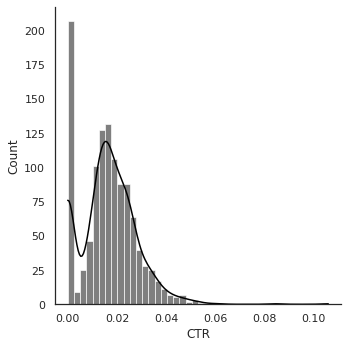

In [ ]:
sns.displot(data=output.select('CTR', 'prediction').toPandas(), x='CTR', kde=True, color ='#000000')

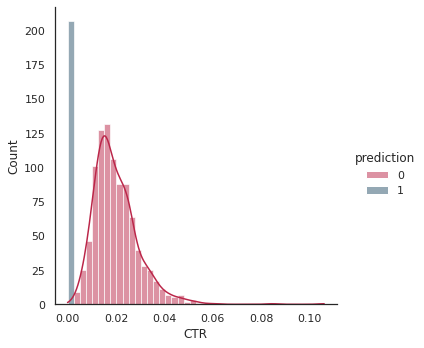

In [ ]:
sns.displot(data=output.select('CTR', 'prediction').toPandas(), x='CTR', kde=True, hue='prediction', palette =['#BB2649','#2B526B'])

## Clustering based on AR

We can see that there are 3 modes in the AR, hence we first bring this to an unsupervised task. We try to cluster the customers into 3 clusters, using (AR) which are variables related to sales/revenue.

In [ ]:
df_ar_drop = df.na.drop(subset=["AR"])

In [ ]:
from pyspark.ml.feature import VectorAssembler
assemble=VectorAssembler(inputCols=['AR'], outputCol='features')
assembled_data=assemble.transform(df_ar_drop)

In [ ]:
assembled_data.show()

+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+------------------+--------------------+--------------------+--------------------+-----+--------+
| ad_id|xyz_campaign_id|fb_campaign_id|  age|gender|interest|Impressions|Clicks|      Spent|Total_Conversion|Approved_Conversion|               CPC|                 CTR|                 TCR|                 ACR|   AR|features|
+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+------------------+--------------------+--------------------+--------------------+-----+--------+
|708746|            916|        103916|30-34|     M|      15|       7350|     1|1.429999948|               2|                  1|       1.429999948|0.013605442176870748|0.027210884353741496|0.013605442176870748| 50.0|  [50.0]|
|708749|            916|        103917|30-34|     M|      16|      17861|     2|1.820000023|

In [ ]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show()

+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+------------------+--------------------+--------------------+--------------------+-----+--------+--------------------+
| ad_id|xyz_campaign_id|fb_campaign_id|  age|gender|interest|Impressions|Clicks|      Spent|Total_Conversion|Approved_Conversion|               CPC|                 CTR|                 TCR|                 ACR|   AR|features|        standardized|
+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+------------------+--------------------+--------------------+--------------------+-----+--------+--------------------+
|708746|            916|        103916|30-34|     M|      15|       7350|     1|1.429999948|               2|                  1|       1.429999948|0.013605442176870748|0.027210884353741496|0.013605442176870748| 50.0|  [50.0]|[1.2451616572297775]|
|708749|

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
    
KMeans_algo=KMeans(featuresCol='standardized', k=3)

KMeans_fit=KMeans_algo.fit(data_scale_output)

output=KMeans_fit.transform(data_scale_output)

score=evaluator.evaluate(output)
    

In [ ]:
output.show()

+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+------------------+--------------------+--------------------+--------------------+-----+--------+--------------------+----------+
| ad_id|xyz_campaign_id|fb_campaign_id|  age|gender|interest|Impressions|Clicks|      Spent|Total_Conversion|Approved_Conversion|               CPC|                 CTR|                 TCR|                 ACR|   AR|features|        standardized|prediction|
+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+------------------+--------------------+--------------------+--------------------+-----+--------+--------------------+----------+
|708746|            916|        103916|30-34|     M|      15|       7350|     1|1.429999948|               2|                  1|       1.429999948|0.013605442176870748|0.027210884353741496|0.013605442176870748| 50.0|  [50.

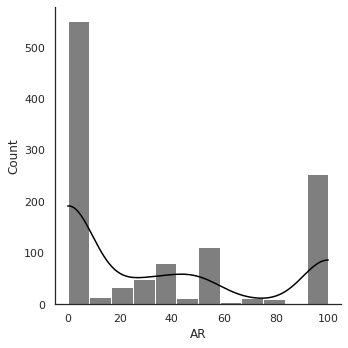

In [ ]:
sns.displot(data=output.select('AR').toPandas(), x='AR', kde=True, color ='#000000')

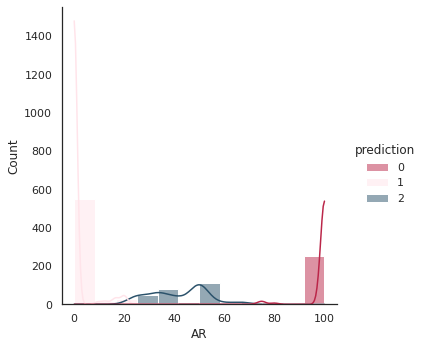

In [ ]:
sns.displot(data=output.select('AR', 'prediction').toPandas(), x='AR', kde=True, hue='prediction', palette =['#BB2649','#FFE4EA','#2B526B'])

# Hypothesis Testing On Conversion Rate

In [ ]:
df.createOrReplaceTempView("df")

In [ ]:
df.show()

+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+------------------+--------------------+--------------------+--------------------+-----+
| ad_id|xyz_campaign_id|fb_campaign_id|  age|gender|interest|Impressions|Clicks|      Spent|Total_Conversion|Approved_Conversion|               CPC|                 CTR|                 TCR|                 ACR|   AR|
+------+---------------+--------------+-----+------+--------+-----------+------+-----------+----------------+-------------------+------------------+--------------------+--------------------+--------------------+-----+
|708746|            916|        103916|30-34|     M|      15|       7350|     1|1.429999948|               2|                  1|       1.429999948|0.013605442176870748|0.027210884353741496|0.013605442176870748| 50.0|
|708749|            916|        103917|30-34|     M|      16|      17861|     2|1.820000023|               2|                  0

In [ ]:
spark.sql("SELECT xyz_campaign_id, avg(TCR), AVG(ACR) FROM df group by xyz_campaign_id ").show()

+---------------+--------------------+--------------------+
|xyz_campaign_id|            avg(TCR)|            avg(ACR)|
+---------------+--------------------+--------------------+
|            916|  0.0433434396446917|0.013687973603433455|
|            936| 0.05445478106855005|0.022755053485587855|
|           1178|0.002006955842373635|6.440969788276846E-4|
+---------------+--------------------+--------------------+



In [ ]:
def uni_eda(feat, ftype, scale=None, prob=False, agg='count', palette=None, font_scale=2):
  spark.sql("SELECT COUNT(DISTINCT {}) FROM df".format(feat)).show()
  spark.sql("SELECT DISTINCT {} FROM df".format(feat)).show()

  spark.sql("SELECT {0},count(*) \
            FROM df \
            GROUP BY {0}".format(feat)).show()

  spark.sql("SELECT {0}, {1}(TCR) TCR, \
            {1}(ACR) ACR \
            FROM df \
            GROUP BY {0}".format(feat, agg)).show()
  sns.set(font_scale = font_scale)
  sns.set_style('whitegrid')
  sns.barplot(
        x=feat, 
        y='count', 
        data=spark.sql("SELECT {0},count(*) count \
            FROM df \
            GROUP BY {0}".format(feat)).toPandas(),
        palette=palette
    )
  plt.savefig("{}_uni.png".format(feat))
  
  # sns.set(font_scale = 2)
  fig, axes=plt.subplots(nrows=1, ncols=2, figsize=(50,10))
  i=0
  for col in ['TCR', 'ACR']:
    sns.set_style('whitegrid')
    sns.barplot(
        x=feat, 
        y=col, 
        data=spark.sql("SELECT {0}, {1}(TCR) TCR, \
                {1}(ACR) ACR \
                FROM df \
                GROUP BY {0}".format(feat, agg)).toPandas(),
                palette=palette,
        ax=axes[i]
    )    
    if scale:
      axes[i].set_yscale(scale)
    # axes[i].set_ylabel(col, fontsize=40)
    # axes[i].set_xlabel(feat, fontsize=40)
    # axes[i].set_yticklabels(fontsize=40)
    # axes[i].set_xticklabels(fontsize=40)
    i += 1    
  sns.despine()
  plt.savefig("{}_conversion_rate.png".format(feat))


+-------------------+
|count(DISTINCT age)|
+-------------------+
|                  4|
+-------------------+

+-----+
|  age|
+-----+
|30-34|
|35-39|
|45-49|
|40-44|
+-----+

+-----+--------+
|  age|count(1)|
+-----+--------+
|30-34|     426|
|35-39|     248|
|45-49|     259|
|40-44|     210|
+-----+--------+

+-----+--------------------+--------------------+
|  age|                 TCR|                 ACR|
+-----+--------------------+--------------------+
|30-34|0.033813702086295104|0.015259430915005513|
|35-39|0.019070433977986495|0.005322400012964302|
|45-49| 0.02016066806325136|0.005806946428783446|
|40-44|0.021458065782950664|0.011312305264776527|
+-----+--------------------+--------------------+



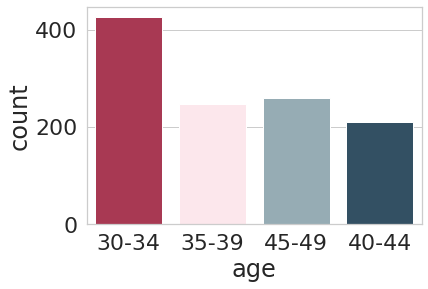

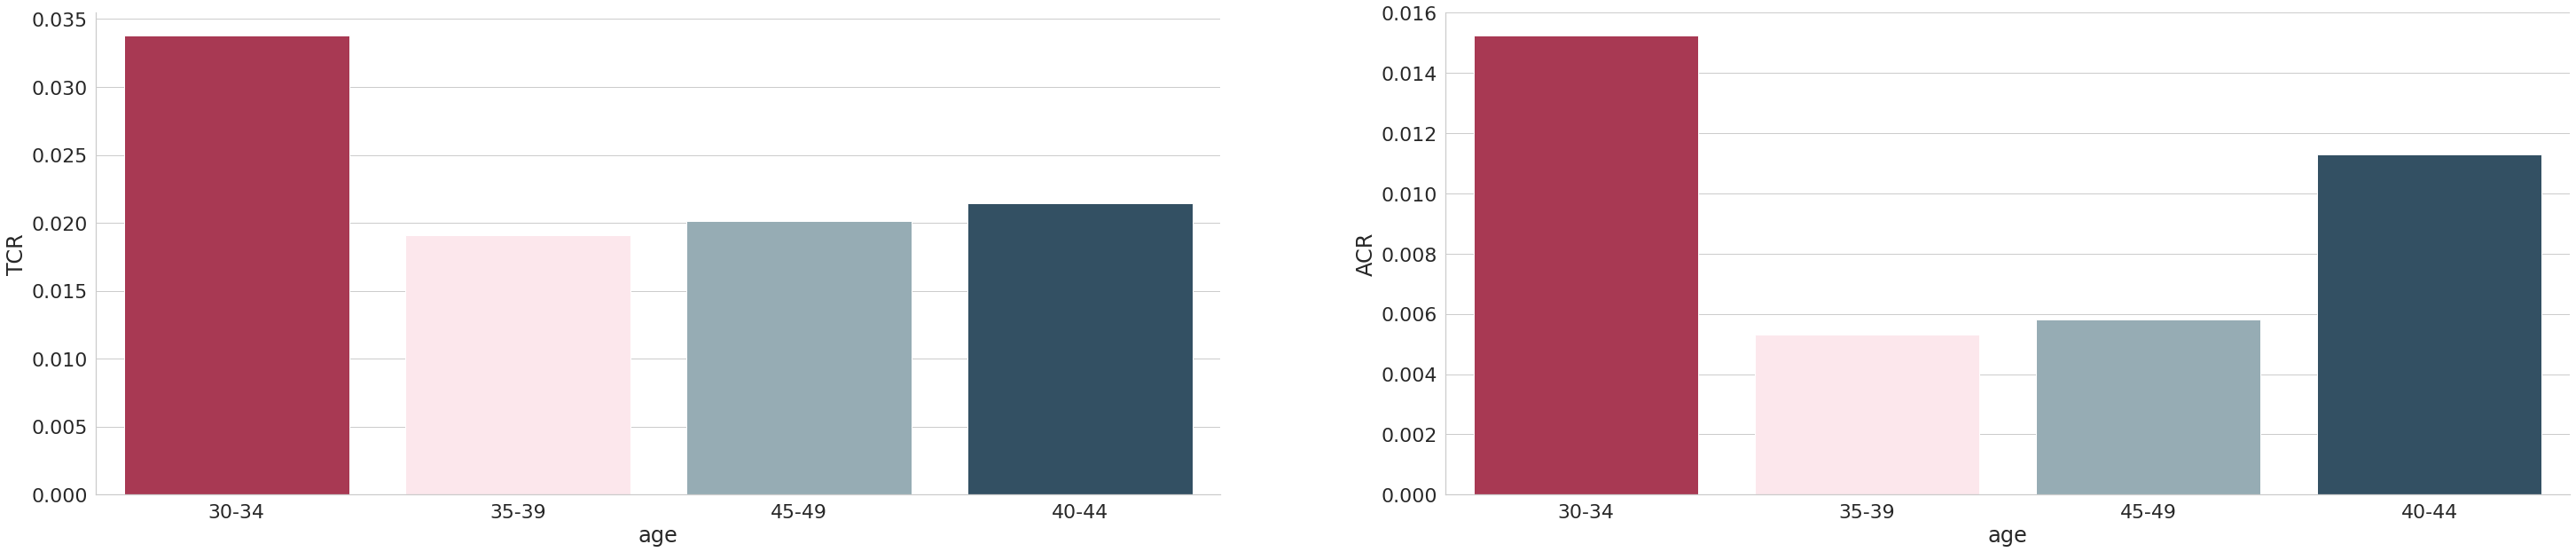

In [ ]:
uni_eda("age", "cat", agg='AVG', palette=['#BB2649','#FFE4EA', '#91AEB9' ,'#2B526B'])

In [ ]:
from pyspark.sql.functions import mean, variance, count
from scipy.stats import t
from math import sqrt
from pyspark.sql.functions import mean, variance
from math import sqrt

def one_sided_test(df, feat, vals, test_col, sample_rate=0.2):
  samples_1 = spark.sql("SELECT {0}, * FROM df WHERE {0} = '{1}'".format(feat, vals[0]))
  samples_2 = spark.sql("SELECT {0}, * FROM df WHERE {0} = '{1}'".format(feat, vals[1]))

  mean_1, var_1, count_1 = tuple(samples_1.select(mean(test_col), variance(test_col), count(test_col)).collect()[0])
  mean_2, var_2, count_2 = tuple(samples_2.select(mean(test_col), variance(test_col), count(test_col)).collect()[0])

  numerator = mean_1 - mean_2
  denominator = sqrt((var_1 / count_1) + (var_2 / count_2))
  t_test_statistic = numerator / denominator

  degrees_of_freedom = count_1 + count_2 - 2
  p_value = 1- t.cdf(t_test_statistic, df = degrees_of_freedom)

  print("Probability that the two have the same distribution:", p_value > 0.05)
  return p_value

In [ ]:
one_sided_test(df, 'age', ['30-34', '35-39'], 'TCR')

Probability that the two have the same distribution: False


0.0013050879152307626

In [ ]:
one_sided_test(df, 'age', ['30-34', '45-49'], 'TCR')

Probability that the two have the same distribution: False


0.004738328335160524

In [ ]:
one_sided_test(df, 'age', ['30-34', '40-44'], 'TCR')

Probability that the two have the same distribution: False


0.04428330676481895

In [ ]:
one_sided_test(df, 'age', ['30-34', '35-39'], 'ACR')
one_sided_test(df, 'age', ['30-34', '45-49'], 'ACR')
one_sided_test(df, 'age', ['30-34', '40-44'], 'TCR')

Probability that the two have the same distribution: False
Probability that the two have the same distribution: False
Probability that the two have the same distribution: False


0.04428330676481895